In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
from dask.diagnostics import ProgressBar
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
import seaborn as sns
import scanpy as sc

# load adata for count matrix

In [2]:
adata = sc.read('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/trajectory_with_Rik_model_output/wave2_steroid_2021_covid_GPLVM.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 17256 × 32913
    obs: 'annot4', 'centre', 'sample_id', 'sample_id_broad', 'sample_date', 'sample_date_yr', 'pool', 'pool_broad', 'haniffa_broad_predLabel', 'orig.ident', 'merged_souporcell_cluster', 'merged_souporcell_status', 'patient_id', 'case_control', 'WHO_severity', 'WHO_temp_severity', 'sex', 'calc_age', 'discharge_date', 'date_positive_swab', 'date_first_symptoms', 'admission_date', 'ethnicity', 'individual_id', 'pseudotime_GPLVM', 'pseudobatch_GPLVM', 'steroid_date', 'days_from_steroid', 'time_from_first_symptoms', 'time_from_positive_swab', 'time_from_infection'
    var: 'GEX'

In [4]:
'C141' in list(adata.obs['sample_id_broad'].unique())

False

In [5]:
adata.obs['days_from_steroid']=adata.obs['days_from_steroid'].astype(float)

In [6]:
adata.obs['steroid_timeline']='unknown'
adata.obs.loc[adata.obs["days_from_steroid"]<=0, "steroid_timeline"] = 'before_steroid'
adata.obs.loc[adata.obs["days_from_steroid"]>0, "steroid_timeline"] = 'after_steroid'

In [7]:
adata.obs['steroid_timeline']=adata.obs['steroid_timeline'].astype('category')

In [8]:
adata.obs['steroid_timeline'].unique()

['after_steroid', 'before_steroid']
Categories (2, object): ['after_steroid', 'before_steroid']

In [9]:
list(adata.obs['annot4'].unique())

['HSPC',
 'Platelet',
 'RBC',
 'CD14mono',
 'CD16mono',
 'Int.mono',
 'CD14mono_anti_inflammatory',
 'CD14mono_IFN',
 'CD14mono_activated',
 'CD16mono_IFN',
 'CD16mono_C1',
 'DC3_IFN',
 'DC2',
 'pDC',
 'DC3',
 'DC1',
 'ASDC']

In [10]:
adata = adata[adata.obs['annot4'].isin(['CD14mono','CD14mono_IFN','CD14mono_activated','CD14mono_anti_inflammatory'])]

In [12]:
#gettting count matrix
ex_matrix = pd.DataFrame(adata.X.toarray())
ex_matrix.columns = adata.var.index
ex_matrix.index = adata.obs.index

In [13]:
# define data folder and files
DATA_FOLDER="/home/jovyan/scripts/renal_covid_19/steroid_pipeline/regulon_analysis/"
RESOURCES_FOLDER="/lustre/scratch117/cellgen/team298/win/regulon_own_data/"
DATABASES_GLOB = os.path.join(RESOURCES_FOLDER, "hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather")#from https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl") #from https://resources.aertslab.org/cistarget/
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'lambert2018.txt') # from https://github.com/aertslab/pySCENIC/blob/master/resources/lambert2018.txt
REGULONS_FNAME = os.path.join(DATA_FOLDER, "CD14_wave2_steroid_2021.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "CD14_wave2_steroid_2021.csv")


In [14]:
DATABASES_GLOB

'/lustre/scratch117/cellgen/team298/win/regulon_own_data/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather'

In [15]:
ex_matrix.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
UK-CIC10690366+UK-CIC10690558_AACTTTCCAAGTCATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK-CIC10690366+UK-CIC10690558_TATTACCAGAGTAATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK-CIC10690367+UK-CIC10690559_TTGGCAAGTATATGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK-CIC10690325+UK-CIC10690517_GCGCGATCACCCAGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK-CIC10690319+UK-CIC10690511_GCTTGAAAGATCCCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# calculate adjacencies - co expression genes and TF

In [16]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [17]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr")]

In [18]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)


preparing dask client
parsing input
creating dask graph
5 partitions
computing dask graph
shutting down client and local cluster


2022-07-02 15:45:19,257 - distributed.nanny - WARNING - Worker process still alive after 3.999998474121094 seconds, killing
2022-07-02 15:45:19,259 - distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing
2022-07-02 15:45:19,260 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
2022-07-02 15:45:19,261 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
2022-07-02 15:45:19,263 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing


finished


In [19]:
adjacencies

,TF,target,importance
748,IRF7,IFITM3,1.949168e+02
43,YBX1,RPL10,1.802012e+02
748,IRF7,LY6E,1.767439e+02
43,YBX1,PFN1,1.764510e+02
43,YBX1,ACTB,1.755395e+02
...,...,...,...
701,KLF9,AC091138.1,9.813898e-24
471,ZNF316,C3orf52,6.795623e-24
1195,SMAD4,C4B,5.848466e-24
43,YBX1,GML,5.679205e-24


In [21]:
adjacencies.to_csv('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/regulon_analysis/adjacencies_CD14_wave2_steroid_2021.csv')

In [22]:
# Derive modules from adjacencies
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2022-07-02 16:35:39,584 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-07-02 16:35:40,763 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-07-02 16:36:36,156 - pyscenic.utils - INFO - Creating modules.


# pruning for enriched motif

In [23]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)
# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

[                                        ] | 0% Completed | 38.7s


2022-07-02 16:41:10,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.0s


2022-07-02 16:41:11,142 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AC023509.3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.2s


2022-07-02 16:41:11,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,366 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AC092835.1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF692 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.6s


2022-07-02 16:41:11,761 - pyscenic.transform - WARNING - Less than 80% of the genes in PURB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:11,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.1s


2022-07-02 16:41:12,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.3s


2022-07-02 16:41:12,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:12,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.7s


2022-07-02 16:41:12,855 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:12,935 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.9s


2022-07-02 16:41:13,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF697 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:13,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:13,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.3s


2022-07-02 16:41:13,429 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:13,519 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:13,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.5s


2022-07-02 16:41:13,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:13,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:13,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.7s


2022-07-02 16:41:13,884 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCML4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:13,991 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,007 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.0s


2022-07-02 16:41:14,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.4s


2022-07-02 16:41:14,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,506 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF700 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,627 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.7s


2022-07-02 16:41:14,730 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:14,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.0s


2022-07-02 16:41:15,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:15,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:15,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF608 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:15,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.4s


2022-07-02 16:41:15,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF609 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:15,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:15,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:15,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF805 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.6s


2022-07-02 16:41:15,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SGSM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.9s


2022-07-02 16:41:15,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,004 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.3s


2022-07-02 16:41:16,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,528 - pyscenic.transform - WARNING - Less than 80% of the genes in RBCK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.6s


2022-07-02 16:41:16,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,852 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF709 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,866 - pyscenic.transform - WARNING - Less than 8

[                                        ] | 0% Completed | 44.8s


2022-07-02 16:41:16,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SLC2A4RG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,992 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:16,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,098 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.1s


2022-07-02 16:41:17,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.4s


2022-07-02 16:41:17,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.6s


2022-07-02 16:41:17,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMYD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.8s


2022-07-02 16:41:17,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:17,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,006 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,124 - pyscenic.transform - WARNING - Less tha

[                                        ] | 0% Completed | 46.0s


2022-07-02 16:41:18,149 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF816 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,265 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,293 - pyscenic.transform - WARNING - Less tha

[                                        ] | 0% Completed | 46.2s


2022-07-02 16:41:18,369 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF724 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.4s


2022-07-02 16:41:18,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,620 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF827 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,651 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,694 - pyscenic.transform - WARNING - Less than 

[                                        ] | 0% Completed | 46.8s


2022-07-02 16:41:18,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF83 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:18,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,052 - pyscenic.transform - WARNING - Less than 

[                                        ] | 0% Completed | 47.0s


2022-07-02 16:41:19,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,299 - pyscenic.transform - WARNING - Less than 80% of the 

[                                        ] | 0% Completed | 47.2s


2022-07-02 16:41:19,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,508 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,517 - pyscenic.transform - WARNING - Less than 8

[                                        ] | 0% Completed | 47.5s


2022-07-02 16:41:19,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,660 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,758 - pyscenic.transform - WARNING - Less than

[                                        ] | 0% Completed | 47.7s


2022-07-02 16:41:19,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF644 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:19,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,016 - pyscenic.transform - WARNING - Less than 

[                                        ] | 0% Completed | 47.9s


2022-07-02 16:41:20,059 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,193 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,215 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Re

[                                        ] | 0% Completed | 48.2s


2022-07-02 16:41:20,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,353 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,507 - pyscenic.transform - WARNING - Less than 80% of the

[                                        ] | 0% Completed | 48.4s


2022-07-02 16:41:20,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,635 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,748 - pyscenic.transform - WARNING - Less than 80% of the ge

[                                        ] | 0% Completed | 48.6s


2022-07-02 16:41:20,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,766 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:20,902 - pyscenic.transform - WARNING - Less than 80% of the ge

[                                        ] | 0% Completed | 48.8s


2022-07-02 16:41:21,018 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF747 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,089 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,112 - pyscenic.transform - WARNING - Less than 80% of the genes in REXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,134 - pyscenic.transform - WARNING - Less than 80% of the gen

[                                        ] | 0% Completed | 49.1s


2022-07-02 16:41:21,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,404 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 49.5s


2022-07-02 16:41:21,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,725 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,757 - pyscenic.transform - WARNING - Less than 80% of the

[                                        ] | 0% Completed | 49.7s


2022-07-02 16:41:21,801 - pyscenic.transform - WARNING - Less than 80% of the genes in POGK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,805 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,928 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:21,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[                                        ] | 0% Completed | 49.9s


2022-07-02 16:41:22,023 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,048 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,113 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,148 - pyscenic.transform - WARNING - Less than 80% of the

[                                        ] | 0% Completed | 50.1s


2022-07-02 16:41:22,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,333 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,389 - pyscenic.transform - WARNING - Less than 80% of the g

[                                        ] | 0% Completed | 50.4s


2022-07-02 16:41:22,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,589 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,688 - pyscenic.transform - WARNING - Less than 80% of the

[                                        ] | 0% Completed | 50.6s


2022-07-02 16:41:22,714 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,829 - pyscenic.transform - WARNING - Less tha

[                                        ] | 0% Completed | 50.9s


2022-07-02 16:41:22,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:22,949 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,006 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,050 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,059 - pyscenic.transform - WARNING - Less than 80% of the

[                                        ] | 0% Completed | 51.1s


2022-07-02 16:41:23,194 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.3s


2022-07-02 16:41:23,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,443 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,506 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,507 - pyscenic.transform - WARNING - Less than 80% of the

[                                        ] | 0% Completed | 51.5s


2022-07-02 16:41:23,612 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,623 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,813 - pyscenic.transform - WARNING - Less than 80% of the ge

[                                        ] | 0% Completed | 51.7s


2022-07-02 16:41:23,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:23,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,018 - pyscenic.transform - WARNING - Less than 80% of t

[                                        ] | 0% Completed | 51.9s


2022-07-02 16:41:24,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,142 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,226 - pyscenic.transform - WARNING

[                                        ] | 0% Completed | 52.2s


2022-07-02 16:41:24,261 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,412 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.4s


2022-07-02 16:41:24,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF888 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,494 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,555 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.6s


2022-07-02 16:41:24,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,887 - pyscenic.transform - WARNING

[                                        ] | 0% Completed | 52.8s


2022-07-02 16:41:24,909 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,949 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,961 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:24,989 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,039 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 c

[                                        ] | 0% Completed | 53.0s


2022-07-02 16:41:25,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,222 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,303 - pyscenic.transform - WARNING - Less tha

[                                        ] | 0% Completed | 53.3s


2022-07-02 16:41:25,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF93 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,499 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,499 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,525 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,615 - pyscenic.transform - WARNING - Less than 80% of the ge

[                                        ] | 0% Completed | 53.5s


2022-07-02 16:41:25,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,626 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:25,786 - pyscenic.transform - WARNING - Less than 

[                                        ] | 0% Completed | 53.7s


2022-07-02 16:41:25,830 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 53.9s


2022-07-02 16:41:26,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AC023509.3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,115 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AC092835.1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.2s


2022-07-02 16:41:26,331 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,345 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,532 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.4s


2022-07-02 16:41:26,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,651 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.6s


2022-07-02 16:41:26,801 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,898 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,930 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:26,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.8s


2022-07-02 16:41:27,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,194 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.1s


2022-07-02 16:41:27,242 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.3s


2022-07-02 16:41:27,486 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF724 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.6s


2022-07-02 16:41:27,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:27,889 - pyscenic.transform - WARNING - Less than 80% of th

[                                        ] | 0% Completed | 55.8s


2022-07-02 16:41:27,913 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,007 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,012 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,015 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,059 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.1s


2022-07-02 16:41:28,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,186 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,201 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,204 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,233 - pyscenic.transform - WARNING - Less than 

[                                        ] | 0% Completed | 56.3s


2022-07-02 16:41:28,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF737 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,447 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,490 - pyscenic.transform - WARNING - Less than 8

[                                        ] | 0% Completed | 56.5s


2022-07-02 16:41:28,597 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,626 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,692 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,703 - pyscenic.transform - WARNING - Less than 80% of the 

[                                        ] | 0% Completed | 56.7s


2022-07-02 16:41:28,826 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF850 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF747 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHDC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:28,996 - pyscenic.transform - WARNING - Less than 80% of the 

[                                        ] | 0% Completed | 56.9s


2022-07-02 16:41:29,040 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.2s


2022-07-02 16:41:29,343 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHDC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.5s


2022-07-02 16:41:29,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,594 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,716 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.7s


2022-07-02 16:41:29,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,847 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:29,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.0s


2022-07-02 16:41:30,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF609 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.3s


2022-07-02 16:41:30,411 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,489 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF853 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,545 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,589 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.5s


2022-07-02 16:41:30,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF865 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,803 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,849 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[                                        ] | 0% Completed | 58.7s


2022-07-02 16:41:30,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:30,950 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,001 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,015 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.9s


2022-07-02 16:41:31,101 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,105 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,126 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,189 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8

[                                        ] | 0% Completed | 59.1s


2022-07-02 16:41:31,303 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,334 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,353 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,490 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.4s


2022-07-02 16:41:31,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,537 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,631 - pyscenic.transform - WARNING - Less than 80% of the genes in PREB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF9

[                                        ] | 0% Completed | 59.6s


2022-07-02 16:41:31,738 - pyscenic.transform - WARNING - Less than 80% of the genes in PRMT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,851 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSC

[                                        ] | 0% Completed | 59.8s


2022-07-02 16:41:31,956 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:31,998 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,029 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Reg

[                                        ] | 0% Completed |  1min  0.0s


2022-07-02 16:41:32,192 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,213 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,229 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,303 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Reg

[                                        ] | 0% Completed |  1min  0.2s


2022-07-02 16:41:32,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,411 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,427 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.4s


2022-07-02 16:41:32,624 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,724 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.8s


2022-07-02 16:41:32,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:32,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.0s


2022-07-02 16:41:33,040 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,190 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.2s


2022-07-02 16:41:33,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,400 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,441 - pyscenic.transform - WARNING - Less than 80% of the g

[                                        ] | 0% Completed |  1min  1.5s


2022-07-02 16:41:33,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,537 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,538 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 co

[                                        ] | 0% Completed |  1min  1.7s


2022-07-02 16:41:33,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,922 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:33,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.0s


2022-07-02 16:41:34,041 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,139 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.2s


2022-07-02 16:41:34,251 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,316 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,389 - pyscenic.transform - WARNING - Less than 80% of the genes in SCML4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.4s


2022-07-02 16:41:34,488 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,588 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,660 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.6s


2022-07-02 16:41:34,698 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,811 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:34,903 - pyscenic.transform - WARNING - Less than 80% of the genes in SG

[                                        ] | 0% Completed |  1min  2.9s


2022-07-02 16:41:34,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,014 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,048 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,088 - pyscenic.transform - WARNING - Less than 80% of the genes in AC023509.3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ANKZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,116 - pyscenic.transform - WARNING - Less than 80% of th

[                                        ] | 0% Completed |  1min  3.1s


2022-07-02 16:41:35,215 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,319 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,321 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,404 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,414 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC2A4RG

[                                        ] | 0% Completed |  1min  3.3s


2022-07-02 16:41:35,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,499 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,538 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  3.5s


2022-07-02 16:41:35,645 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,794 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  3.8s


2022-07-02 16:41:35,912 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:35,945 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,007 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,048 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,091 - pyscenic.transform - WARNING - Less than 80% of the g

[                                        ] | 0% Completed |  1min  4.0s


2022-07-02 16:41:36,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,190 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,264 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,310 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.2s


2022-07-02 16:41:36,338 - pyscenic.transform - WARNING - Less than 80% of the genes in RBCK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.5s


2022-07-02 16:41:36,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,641 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,722 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.7s


2022-07-02 16:41:36,836 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,935 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:36,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,007 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,030 - pyscenic.transform - WARNING - Less than 80% of the 

[                                        ] | 0% Completed |  1min  5.0s


2022-07-02 16:41:37,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,132 - pyscenic.transform - WARNING - Less than 80% of the genes in SMYD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,235 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.2s


2022-07-02 16:41:37,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,338 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,456 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.4s


2022-07-02 16:41:37,533 - pyscenic.transform - WARNING - Less than 80% of the genes in AC092835.1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,593 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,651 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,724 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.6s


2022-07-02 16:41:37,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,845 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:37,944 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.9s


2022-07-02 16:41:38,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,056 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,187 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,189 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.1s


2022-07-02 16:41:38,239 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,336 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,343 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF853 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.3s


2022-07-02 16:41:38,443 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF860 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,545 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF865 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.6s


2022-07-02 16:41:38,651 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,694 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,751 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[                                        ] | 0% Completed |  1min  6.8s


2022-07-02 16:41:38,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:38,952 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,009 - pyscenic.transform - WARNING - Less than 80% of the genes in ANKZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,013 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,095 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.0s


2022-07-02 16:41:39,118 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,216 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,298 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,317 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF888 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.2s


2022-07-02 16:41:39,329 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,496 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.5s


2022-07-02 16:41:39,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF90 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,729 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ANKZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.8s


2022-07-02 16:41:39,887 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:39,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,054 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.0s


2022-07-02 16:41:40,117 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,247 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.2s


2022-07-02 16:41:40,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,331 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,351 - pyscenic.transform - WARNING - Less than 80% of the genes in ARHGAP35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,434 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Z

[                                        ] | 0% Completed |  1min  8.4s


2022-07-02 16:41:40,532 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,701 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69

[                                        ] | 0% Completed |  1min  8.6s


2022-07-02 16:41:40,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,812 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,840 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Z

[                                        ] | 0% Completed |  1min  8.9s


2022-07-02 16:41:40,955 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:40,999 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,117 - pyscenic.transform - WARNING - Less than 80% of the genes in ARHGAP35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon 

[                                        ] | 0% Completed |  1min  9.1s


2022-07-02 16:41:41,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,299 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,331 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSC

[                                        ] | 0% Completed |  1min  9.3s


2022-07-02 16:41:41,438 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,445 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,523 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 

[                                        ] | 0% Completed |  1min  9.5s


2022-07-02 16:41:41,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,733 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.8s


2022-07-02 16:41:41,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:41,953 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,098 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT

[                                        ] | 0% Completed |  1min 10.0s


2022-07-02 16:41:42,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,236 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,259 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 10.2s


2022-07-02 16:41:42,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,347 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,390 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,390 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,393 - pyscenic.transform - WARNING - Less than 80% of the genes in REXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 

[                                        ] | 0% Completed |  1min 10.4s


2022-07-02 16:41:42,592 - pyscenic.transform - WARNING - Less than 80% of the genes in AC092835.1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 10.6s


2022-07-02 16:41:42,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:42,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 10.9s


2022-07-02 16:41:43,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ST18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:43,091 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:43,119 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:43,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 11.1s


2022-07-02 16:41:43,305 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:43,399 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 11.6s


2022-07-02 16:41:43,793 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:43,839 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:43,891 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 11.9s


2022-07-02 16:41:44,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 12.5s


2022-07-02 16:41:44,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:44,612 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:44,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 13.0s


2022-07-02 16:41:45,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,116 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,140 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,194 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 13.2s


2022-07-02 16:41:45,291 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,311 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,312 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,357 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,416 - pyscenic.transform - WARNING - Less than 80% of the genes i

[                                        ] | 0% Completed |  1min 13.4s


2022-07-02 16:41:45,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,553 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 13.7s


2022-07-02 16:41:45,803 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:45,840 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 14.0s


2022-07-02 16:41:46,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:46,209 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:46,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 14.3s


2022-07-02 16:41:46,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:46,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:46,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 14.5s


2022-07-02 16:41:46,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:46,699 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:46,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:46,832 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 14.8s


2022-07-02 16:41:46,939 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,053 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,113 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 15.1s


2022-07-02 16:41:47,230 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,236 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF724 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,391 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,424 - pyscenic.transform - WARNING - Less than 80% of the genes in RORB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 15.3s


2022-07-02 16:41:47,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 15.5s


2022-07-02 16:41:47,699 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 15.8s


2022-07-02 16:41:47,916 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:47,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:48,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:48,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:48,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 16.1s


2022-07-02 16:41:48,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:48,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF737 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 16.3s


2022-07-02 16:41:48,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:48,555 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 16.7s


2022-07-02 16:41:48,843 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:49,025 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF747 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 16.9s


2022-07-02 16:41:49,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:49,123 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:49,214 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:49,255 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 17.2s


2022-07-02 16:41:49,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:49,449 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 17.4s


2022-07-02 16:41:49,622 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:49,647 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 17.9s


2022-07-02 16:41:49,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 18.2s


2022-07-02 16:41:50,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 18.4s


2022-07-02 16:41:50,434 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:50,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 18.7s


2022-07-02 16:41:50,756 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:50,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:50,836 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:50,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 19.0s


2022-07-02 16:41:51,048 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 19.2s


2022-07-02 16:41:51,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,287 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,424 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 19.4s


2022-07-02 16:41:51,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,502 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,611 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,628 - pyscenic.transform - WARNING - Less than 80% of the genes in BARX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 19.6s


2022-07-02 16:41:51,732 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,751 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:51,859 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 19.9s


2022-07-02 16:41:51,999 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,015 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,030 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 20.2s


2022-07-02 16:41:52,303 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,349 - pyscenic.transform - WARNING - Less than 80% of the genes in SAFB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 20.4s


2022-07-02 16:41:52,542 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,594 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSC22D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,728 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 20.7s


2022-07-02 16:41:52,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:52,924 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 20.9s


2022-07-02 16:41:53,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,059 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,089 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,116 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,159 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 21.1s


2022-07-02 16:41:53,222 - pyscenic.transform - WARNING - Less than 80% of the genes in SCML4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,316 - pyscenic.transform - WARNING - Less than 80% of the genes in SCRT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,405 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 21.3s


2022-07-02 16:41:53,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,521 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,529 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,643 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 21.6s


2022-07-02 16:41:53,786 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:53,894 - pyscenic.transform - WARNING - Less than 80% of the genes in SGSM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 21.9s


2022-07-02 16:41:54,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:54,096 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:54,221 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 22.1s


2022-07-02 16:41:54,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:54,406 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:54,417 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 22.4s


2022-07-02 16:41:54,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:54,720 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 22.8s


2022-07-02 16:41:54,845 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:54,912 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:54,993 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 23.0s


2022-07-02 16:41:55,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL11B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,065 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,107 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,131 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 23.3s


2022-07-02 16:41:55,392 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,508 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 23.5s


2022-07-02 16:41:55,613 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,660 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,723 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC2A4RG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 23.7s


2022-07-02 16:41:55,835 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ANKZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:55,965 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 24.0s


2022-07-02 16:41:56,091 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,092 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,198 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ARHGAP35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 24.2s


2022-07-02 16:41:56,311 - pyscenic.transform - WARNING - Less than 80% of the genes in SMYD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,404 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHA15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 24.5s


2022-07-02 16:41:56,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 24.7s


2022-07-02 16:41:56,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:56,940 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 25.0s


2022-07-02 16:41:57,131 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:57,259 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:57,296 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 25.3s


2022-07-02 16:41:57,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:57,493 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:57,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 25.7s


2022-07-02 16:41:57,792 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:57,922 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:57,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 25.9s


2022-07-02 16:41:58,047 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,087 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,197 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 26.1s


2022-07-02 16:41:58,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,345 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 26.3s


2022-07-02 16:41:58,492 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,532 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BARX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,633 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 26.6s


2022-07-02 16:41:58,755 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:58,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 26.9s


2022-07-02 16:41:59,045 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,140 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 27.1s


2022-07-02 16:41:59,286 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,397 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 27.3s


2022-07-02 16:41:59,509 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,599 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,636 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 27.6s


2022-07-02 16:41:59,787 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,844 - pyscenic.transform - WARNING - Less than 80% of the genes in CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,892 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:41:59,941 - pyscenic.transform - WARNING - Less than 80% of the gene

[                                        ] | 0% Completed |  1min 27.8s


2022-07-02 16:41:59,997 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,090 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,091 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,100 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,112 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,120 - pyscenic.transform - WARNING - Less than 80% of the genes in PO

[                                        ] | 0% Completed |  1min 28.0s


2022-07-02 16:42:00,202 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,309 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,312 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,327 - pyscenic.transform - WARNING - Less than 80% of t

[                                        ] | 0% Completed |  1min 28.3s


2022-07-02 16:42:00,433 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,449 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,519 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 28.5s


2022-07-02 16:42:00,689 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:00,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 29.6s


2022-07-02 16:42:01,658 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:01,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 29.9s


2022-07-02 16:42:01,957 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:01,993 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,008 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL11A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,099 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF853 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,118 - pyscenic.transform - WARNING - Less than 80% of the 

[                                        ] | 0% Completed |  1min 30.1s


2022-07-02 16:42:02,198 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,204 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,292 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 30.3s


2022-07-02 16:42:02,451 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF865 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,487 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,634 - pyscenic.transform - WARNING - Less than 80% of the genes in CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 30.7s


2022-07-02 16:42:02,799 - pyscenic.transform - WARNING - Less than 80% of the genes in CBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,893 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,901 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:02,988 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 31.0s


2022-07-02 16:42:03,104 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:03,149 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:03,250 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 31.4s


2022-07-02 16:42:03,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF888 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:03,537 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:03,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:03,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 31.6s


2022-07-02 16:42:03,720 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:03,834 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF90 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:03,839 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 31.8s


2022-07-02 16:42:04,009 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:04,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:04,199 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 32.2s


2022-07-02 16:42:04,316 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:04,353 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:04,420 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 32.6s


2022-07-02 16:42:04,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:04,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 32.9s


2022-07-02 16:42:05,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 33.6s


2022-07-02 16:42:05,711 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 33.9s


2022-07-02 16:42:05,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:06,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 34.1s


2022-07-02 16:42:06,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL11B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 34.5s


2022-07-02 16:42:06,597 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:06,747 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:06,765 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 34.8s


2022-07-02 16:42:06,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,094 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 35.1s


2022-07-02 16:42:07,188 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,249 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 35.4s


2022-07-02 16:42:07,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 35.6s


2022-07-02 16:42:07,699 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 35.8s


2022-07-02 16:42:07,910 - pyscenic.transform - WARNING - Less than 80% of the genes in PRMT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,917 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:07,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 36.0s


2022-07-02 16:42:08,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:08,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:08,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 36.3s


2022-07-02 16:42:08,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:08,443 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:08,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 36.6s


2022-07-02 16:42:08,731 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:08,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 36.8s


2022-07-02 16:42:08,961 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:09,087 - pyscenic.transform - WARNING - Less than 80% of the genes in PURB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:09,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 37.1s


2022-07-02 16:42:09,260 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:09,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 38.0s


2022-07-02 16:42:10,122 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:10,296 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 38.3s


2022-07-02 16:42:10,409 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:10,455 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:10,559 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 38.5s


2022-07-02 16:42:10,644 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:10,827 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 39.0s


2022-07-02 16:42:11,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 39.4s


2022-07-02 16:42:11,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:11,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:11,697 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:11,720 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 39.6s


2022-07-02 16:42:11,788 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:11,957 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 39.9s


2022-07-02 16:42:11,996 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,008 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,050 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,110 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,136 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPS could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 40.1s


2022-07-02 16:42:12,222 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,322 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 40.3s


2022-07-02 16:42:12,432 - pyscenic.transform - WARNING - Less than 80% of the genes in CGGBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,541 - pyscenic.transform - WARNING - Less than 80% of the genes in CHAMP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 40.5s


2022-07-02 16:42:12,635 - pyscenic.transform - WARNING - Less than 80% of the genes in CHCHD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,725 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:12,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 41.3s


2022-07-02 16:42:13,402 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:13,500 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 41.7s


2022-07-02 16:42:13,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:13,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CC2D1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:13,958 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 42.9s


2022-07-02 16:42:15,024 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:15,140 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 43.2s


2022-07-02 16:42:15,308 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 44.0s


2022-07-02 16:42:16,191 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:16,287 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:16,332 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 44.3s


2022-07-02 16:42:16,428 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:16,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:16,550 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:16,560 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 44.6s


2022-07-02 16:42:16,756 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:16,854 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 44.9s


2022-07-02 16:42:17,105 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:17,187 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 45.4s


2022-07-02 16:42:17,529 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:17,696 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 46.2s


2022-07-02 16:42:18,315 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,409 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 46.5s


2022-07-02 16:42:18,610 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,737 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 46.7s


2022-07-02 16:42:18,831 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,888 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:18,937 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CCDC17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,007 - pyscenic.transform - WARNING - Less than 80

[#                                       ] | 4% Completed |  1min 46.9s


2022-07-02 16:42:19,035 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 47.2s


2022-07-02 16:42:19,244 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,359 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 47.4s


2022-07-02 16:42:19,500 - pyscenic.transform - WARNING - Less than 80% of the genes in CGGBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,623 - pyscenic.transform - WARNING - Less than 80% of the genes in CHAMP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 47.6s


2022-07-02 16:42:19,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,730 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,744 - pyscenic.transform - WARNING - Less than 80% of the genes in CHCHD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,845 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,904 - pyscenic.transform - WARNING - Less than 80% o

[#                                       ] | 4% Completed |  1min 47.8s


2022-07-02 16:42:19,939 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:19,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 48.0s


2022-07-02 16:42:20,144 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,203 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,243 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,306 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 48.2s


2022-07-02 16:42:20,345 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,409 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,456 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,506 - pyscenic.transform - WARNING - Less than 80% o

[#                                       ] | 4% Completed |  1min 48.5s


2022-07-02 16:42:20,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,641 - pyscenic.transform - WARNING - Less than 80% of the genes in TET2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,744 - pyscenic.transform - WARNING - Less than 80% of the genes in TET3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 48.7s


2022-07-02 16:42:20,848 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:20,942 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 49.0s


2022-07-02 16:42:21,134 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 49.7s


2022-07-02 16:42:21,819 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:21,901 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:22,003 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 49.9s


2022-07-02 16:42:22,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:22,099 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:22,105 - pyscenic.transform - WARNING - Less than 80% of the genes in BARX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:22,198 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:22,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 50.3s


2022-07-02 16:42:22,397 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:22,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 50.5s


2022-07-02 16:42:22,623 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:22,639 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 51.0s


2022-07-02 16:42:23,187 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:23,298 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 51.4s


2022-07-02 16:42:23,531 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:23,650 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 51.7s


2022-07-02 16:42:23,862 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:23,925 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:23,961 - pyscenic.transform - WARNING - Less than 80% of the genes in DMTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,039 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 51.9s


2022-07-02 16:42:24,086 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,117 - pyscenic.transform - WARNING - Less than 80% of the genes in REXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,211 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,221 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 52.2s


2022-07-02 16:42:24,321 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,345 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,407 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,489 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,502 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 52.4s


2022-07-02 16:42:24,592 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,686 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,703 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 52.7s


2022-07-02 16:42:24,822 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:24,842 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 53.0s


2022-07-02 16:42:25,212 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:25,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ST18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 53.3s


2022-07-02 16:42:25,442 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:25,591 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 53.5s


2022-07-02 16:42:25,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:25,832 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 53.9s


2022-07-02 16:42:25,952 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:26,108 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 54.1s


2022-07-02 16:42:26,207 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:26,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:26,298 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 54.3s


2022-07-02 16:42:26,408 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:26,514 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 54.5s


2022-07-02 16:42:26,619 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:26,665 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:26,722 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 54.7s


2022-07-02 16:42:26,827 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:26,914 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,023 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 55.0s


2022-07-02 16:42:27,058 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,132 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,240 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 55.2s


2022-07-02 16:42:27,343 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,390 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,458 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,486 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 55.5s


2022-07-02 16:42:27,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,569 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,653 - pyscenic.transform - WARNING - Less than 80% of the genes in THYN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,756 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 55.7s


2022-07-02 16:42:27,765 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,816 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,847 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,892 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:27,931 - pyscenic.transform - WARNING - Less than 80% o

[#                                       ] | 4% Completed |  1min 55.9s


2022-07-02 16:42:28,013 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,029 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,125 - pyscenic.transform - WARNING - Le

[#                                       ] | 4% Completed |  1min 56.2s


2022-07-02 16:42:28,318 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,351 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,445 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 56.5s


2022-07-02 16:42:28,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,622 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,719 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 56.7s


2022-07-02 16:42:28,819 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:28,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 57.3s


2022-07-02 16:42:29,412 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 57.7s


2022-07-02 16:42:29,834 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:29,936 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:29,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP73 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 58.0s


2022-07-02 16:42:30,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,153 - pyscenic.transform - WARNING - Less than 80% of the genes in TP73 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,163 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,262 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 58.2s


2022-07-02 16:42:30,361 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,404 - pyscenic.transform - WARNING - Less than 80% of the genes in DMTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 58.4s


2022-07-02 16:42:30,612 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,701 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,765 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 58.8s


2022-07-02 16:42:30,862 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,892 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:30,946 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:31,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:31,031 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 59.0s


2022-07-02 16:42:31,125 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:31,153 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:31,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 59.3s


2022-07-02 16:42:31,363 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:31,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 59.5s


2022-07-02 16:42:31,568 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 59.9s


2022-07-02 16:42:32,023 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:32,025 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  0.1s


2022-07-02 16:42:32,232 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:32,259 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:32,336 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  0.3s


2022-07-02 16:42:32,437 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:32,543 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  0.6s


2022-07-02 16:42:32,657 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  1.2s


2022-07-02 16:42:33,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:33,406 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:33,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZC3H8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:33,515 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:33,540 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  1.5s


2022-07-02 16:42:33,624 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:33,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:33,811 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  1.8s


2022-07-02 16:42:33,903 - pyscenic.transform - WARNING - Less than 80% of the genes in EEA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,054 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  2.0s


2022-07-02 16:42:34,136 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,161 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,248 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,253 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  2.2s


2022-07-02 16:42:34,366 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,487 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  2.6s


2022-07-02 16:42:34,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,713 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:34,819 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  2.8s


2022-07-02 16:42:34,916 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:35,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  3.0s


2022-07-02 16:42:35,139 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  3.3s


2022-07-02 16:42:35,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB33 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:35,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  3.5s


2022-07-02 16:42:35,633 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:35,727 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:35,751 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  3.7s


2022-07-02 16:42:35,910 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:36,050 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  4.0s


2022-07-02 16:42:36,160 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  4.3s


2022-07-02 16:42:36,488 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:36,535 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:36,597 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  4.5s


2022-07-02 16:42:36,697 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:36,702 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:36,827 - pyscenic.transform - WARNING - Less than 80% of the genes in CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  4.8s


2022-07-02 16:42:36,935 - pyscenic.transform - WARNING - Less than 80% of the genes in CBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:37,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:37,036 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:37,098 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  5.1s


2022-07-02 16:42:37,214 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:37,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:37,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:37,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  5.3s


2022-07-02 16:42:37,426 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:37,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  5.6s


2022-07-02 16:42:37,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  5.9s


2022-07-02 16:42:37,947 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:38,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  6.5s


2022-07-02 16:42:38,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:38,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  6.7s


2022-07-02 16:42:38,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:38,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  7.0s


2022-07-02 16:42:39,104 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:39,200 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:39,246 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:39,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  7.2s


2022-07-02 16:42:39,340 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:39,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:39,529 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  7.5s


2022-07-02 16:42:39,558 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:39,705 - pyscenic.transform - WARNING - Less than 80% of the genes in EEA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  7.7s


2022-07-02 16:42:39,842 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:39,997 - pyscenic.transform - WARNING - Less than 80% of the genes in SCML4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  8.0s


2022-07-02 16:42:40,061 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:40,213 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  8.2s


2022-07-02 16:42:40,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:40,362 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:40,468 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  8.7s


2022-07-02 16:42:40,811 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:40,949 - pyscenic.transform - WARNING - Less than 80% of the genes in SGSM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  9.1s


2022-07-02 16:42:41,230 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,424 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  9.4s


2022-07-02 16:42:41,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,704 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  9.6s


2022-07-02 16:42:41,721 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,820 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:41,902 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  9.8s


2022-07-02 16:42:41,923 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,037 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,111 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 10.1s


2022-07-02 16:42:42,209 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,306 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,334 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 10.3s


2022-07-02 16:42:42,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBZF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 10.5s


2022-07-02 16:42:42,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,702 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREM could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,715 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:42,812 - pyscenic.transform - WARNING - L

[#                                       ] | 4% Completed |  2min 10.7s


2022-07-02 16:42:42,887 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC2A4RG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,045 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 11.1s


2022-07-02 16:42:43,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,260 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,361 - pyscenic.transform - 

[#                                       ] | 4% Completed |  2min 11.4s


2022-07-02 16:42:43,464 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,515 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,543 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,590 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,604 - pyscenic.transform - WARNING - Less than 80% of the genes

[#                                       ] | 4% Completed |  2min 11.6s


2022-07-02 16:42:43,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,748 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,899 - pyscenic.transform - WARNING - Less than 80% of the genes in SMYD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 11.8s


2022-07-02 16:42:43,921 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:43,949 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,094 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 12.1s


2022-07-02 16:42:44,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,216 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,293 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 12.3s


2022-07-02 16:42:44,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP64 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 12.7s


2022-07-02 16:42:44,820 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:44,949 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 13.0s


2022-07-02 16:42:45,060 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,186 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,210 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 13.3s


2022-07-02 16:42:45,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,368 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,503 - pyscenic.transform - WARNING - Less 

[#                                       ] | 4% Completed |  2min 13.5s


2022-07-02 16:42:45,619 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,752 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,819 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 13.7s


2022-07-02 16:42:45,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:45,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 13.9s


2022-07-02 16:42:46,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CUX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 14.2s


2022-07-02 16:42:46,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,437 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZMAT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 14.5s


2022-07-02 16:42:46,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZMAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:46,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 14.8s


2022-07-02 16:42:46,941 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:47,092 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 15.0s


2022-07-02 16:42:47,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:47,202 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 15.3s


2022-07-02 16:42:47,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:47,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:47,597 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 15.6s


2022-07-02 16:42:47,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF124 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:47,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:47,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:47,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 15.8s


2022-07-02 16:42:47,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,049 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,107 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 16.0s


2022-07-02 16:42:48,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,230 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 16.2s


2022-07-02 16:42:48,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 16.5s


2022-07-02 16:42:48,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 16.7s


2022-07-02 16:42:48,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:48,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:49,036 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 17.0s


2022-07-02 16:42:49,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:49,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:49,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 17.5s


2022-07-02 16:42:49,536 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 18.3s


2022-07-02 16:42:50,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:50,433 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:50,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:50,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 18.8s


2022-07-02 16:42:50,894 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,009 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 19.0s


2022-07-02 16:42:51,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,166 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 19.2s


2022-07-02 16:42:51,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 19.5s


2022-07-02 16:42:51,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:51,817 - pyscenic.transform - WARNING

[#                                       ] | 4% Completed |  2min 19.8s


2022-07-02 16:42:51,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,039 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZMAT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,118 - pyscenic.transform - WARNING - Less than 80% of the genes in FIGLA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 20.1s


2022-07-02 16:42:52,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,213 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,391 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,395 - pyscenic.transform - WARNING - 

[#                                       ] | 4% Completed |  2min 20.3s


2022-07-02 16:42:52,436 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,508 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,529 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 20.5s


2022-07-02 16:42:52,638 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,720 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,729 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 20.8s


2022-07-02 16:42:52,861 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:52,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 21.0s


2022-07-02 16:42:53,087 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,163 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,264 - pyscenic.transform - WARNING 

[#                                       ] | 4% Completed |  2min 21.2s


2022-07-02 16:42:53,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,455 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 21.5s


2022-07-02 16:42:53,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:53,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 21.8s


2022-07-02 16:42:53,955 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,054 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,117 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 22.0s


2022-07-02 16:42:54,191 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,295 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 22.2s


2022-07-02 16:42:54,399 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,408 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,512 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 22.5s


2022-07-02 16:42:54,648 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,808 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 22.7s


2022-07-02 16:42:54,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,905 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:54,992 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 22.9s


2022-07-02 16:42:55,092 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,198 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 23.1s


2022-07-02 16:42:55,309 - pyscenic.transform - WARNING - Less than 80% of the genes in THYN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,400 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,421 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,490 - pyscenic.transform - WARNING - Less than 80% 

[#                                       ] | 4% Completed |  2min 23.3s


2022-07-02 16:42:55,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,520 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,615 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 23.6s


2022-07-02 16:42:55,751 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,832 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:55,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 23.8s


2022-07-02 16:42:55,998 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF236 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB33 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,128 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 24.1s


2022-07-02 16:42:56,306 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF250 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 24.3s


2022-07-02 16:42:56,517 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,546 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,631 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 24.7s


2022-07-02 16:42:56,732 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:56,924 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 25.0s


2022-07-02 16:42:57,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,056 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,167 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,218 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 25.3s


2022-07-02 16:42:57,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF266 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,546 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGLP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 25.5s


2022-07-02 16:42:57,592 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 25.8s


2022-07-02 16:42:57,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:57,961 - pyscenic.transform - WARNING - Less than 80% of the genes in TP73 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,042 - pyscenic.transform - WARNING - Less than 80% of the genes i

[#                                       ] | 4% Completed |  2min 26.0s


2022-07-02 16:42:58,102 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAFD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,149 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,221 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,239 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 26.2s


2022-07-02 16:42:58,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,335 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,431 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,506 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,517 - pyscenic.transform - WARNING - Less than 80% of t

[#                                       ] | 4% Completed |  2min 26.4s


2022-07-02 16:42:58,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,613 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,735 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 26.7s


2022-07-02 16:42:58,761 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,813 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,844 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,912 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:58,925 - pyscenic.transform - WARNING - Less than 80% of the g

[#                                       ] | 4% Completed |  2min 26.9s


2022-07-02 16:42:59,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,022 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,060 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,121 - pyscenic.transform - WARNING - Less than 80% of the genes

[#                                       ] | 4% Completed |  2min 27.1s


2022-07-02 16:42:59,253 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 27.4s


2022-07-02 16:42:59,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,659 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 27.7s


2022-07-02 16:42:59,804 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:42:59,958 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 27.9s


2022-07-02 16:43:00,059 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,088 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,201 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 28.2s


2022-07-02 16:43:00,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 28.4s


2022-07-02 16:43:00,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 28.6s


2022-07-02 16:43:00,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,831 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,863 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,927 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:00,932 - pyscenic.transform - WARNING - Less than 80% of the gen

[#                                       ] | 4% Completed |  2min 28.8s


2022-07-02 16:43:00,952 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF302 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF148 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 29.0s


2022-07-02 16:43:01,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,198 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,319 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,349 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 29.2s


2022-07-02 16:43:01,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF317 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,447 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 29.5s


2022-07-02 16:43:01,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:01,849 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 29.8s


2022-07-02 16:43:01,920 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 30.2s


2022-07-02 16:43:02,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,425 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 30.5s


2022-07-02 16:43:02,655 - pyscenic.transform - WARNING - Less than 80% of the genes in VSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,748 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,762 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,767 - pyscenic.transform - WARNING - Less than 80% of

[#                                       ] | 4% Completed |  2min 30.8s


2022-07-02 16:43:02,932 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,959 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:02,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,086 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,094 - pyscenic.transform - WARNING - Less than 8

[#                                       ] | 4% Completed |  2min 31.0s


2022-07-02 16:43:03,192 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,261 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,293 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,329 - pyscenic.transform - WARNING - Less than 8

[#                                       ] | 4% Completed |  2min 31.2s


2022-07-02 16:43:03,395 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,493 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 31.4s


2022-07-02 16:43:03,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,662 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 31.7s


2022-07-02 16:43:03,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:03,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,010 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 32.0s


2022-07-02 16:43:04,103 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,106 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,195 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,259 - pyscenic.transform - WARNING - Less than 8

[#                                       ] | 4% Completed |  2min 32.3s


2022-07-02 16:43:04,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,409 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF366 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,525 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 32.6s


2022-07-02 16:43:04,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 32.8s


2022-07-02 16:43:04,936 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:04,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 33.1s


2022-07-02 16:43:05,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF189 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 33.3s


2022-07-02 16:43:05,431 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 33.7s


2022-07-02 16:43:05,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:05,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 33.9s


2022-07-02 16:43:06,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,195 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 34.2s


2022-07-02 16:43:06,298 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,404 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 34.4s


2022-07-02 16:43:06,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,555 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 34.6s


2022-07-02 16:43:06,759 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 34.8s


2022-07-02 16:43:06,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:06,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 35.1s


2022-07-02 16:43:07,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,351 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 35.3s


2022-07-02 16:43:07,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,568 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 35.5s


2022-07-02 16:43:07,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,749 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,854 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 35.7s


2022-07-02 16:43:07,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:07,939 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 36.1s


2022-07-02 16:43:08,214 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:08,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP64 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 36.5s


2022-07-02 16:43:08,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:08,648 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:08,744 - pyscenic.transform - WARNING - Less than 80% of the genes in SPDEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:08,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 36.7s


2022-07-02 16:43:08,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:08,992 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 37.0s


2022-07-02 16:43:09,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF404 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,391 - pyscenic.transform - WARNIN

[#                                       ] | 4% Completed |  2min 37.3s


2022-07-02 16:43:09,441 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,617 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 37.5s


2022-07-02 16:43:09,699 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,861 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 37.9s


2022-07-02 16:43:09,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:09,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF417 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,059 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,119 - pyscenic.transform - WARNING - Less than 80

[#                                       ] | 4% Completed |  2min 38.1s


2022-07-02 16:43:10,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,211 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,301 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,307 - pyscenic.transform - WARNIN

[#                                       ] | 4% Completed |  2min 38.3s


2022-07-02 16:43:10,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,510 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 38.5s


2022-07-02 16:43:10,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,712 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,745 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,761 - pyscenic.transform - WARNING

[#                                       ] | 4% Completed |  2min 38.8s


2022-07-02 16:43:10,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,855 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:10,959 - pyscenic.transform - WARNING - Less tha

[#                                       ] | 4% Completed |  2min 39.0s


2022-07-02 16:43:11,065 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,101 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 39.2s


2022-07-02 16:43:11,300 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZMAT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,310 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,494 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,497 - pyscenic.transform - WARNING - 

[#                                       ] | 4% Completed |  2min 39.5s


2022-07-02 16:43:11,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,611 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:11,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 39.7s


2022-07-02 16:43:11,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,001 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 40.0s


2022-07-02 16:43:12,139 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,243 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 40.2s


2022-07-02 16:43:12,346 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,530 - pyscenic.transform - WARNING - Less than 80% of the 

[#                                       ] | 4% Completed |  2min 40.5s


2022-07-02 16:43:12,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,642 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF277 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF460 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,733 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,746 - pyscenic.transform - WARNING - Less than 80% of the 

[#                                       ] | 4% Completed |  2min 40.8s


2022-07-02 16:43:12,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,929 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:12,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,049 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,059 - pyscenic.transform - WARNING - Less than 80% of the genes in

[#                                       ] | 4% Completed |  2min 41.1s


2022-07-02 16:43:13,258 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,428 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 41.4s


2022-07-02 16:43:13,528 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:13,636 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 41.7s


2022-07-02 16:43:13,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 42.0s


2022-07-02 16:43:14,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 42.2s


2022-07-02 16:43:14,399 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,497 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 42.5s


2022-07-02 16:43:14,630 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,631 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 42.7s


2022-07-02 16:43:14,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,869 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:14,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 42.9s


2022-07-02 16:43:15,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF292 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,201 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 43.2s


2022-07-02 16:43:15,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,332 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,395 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 43.4s


2022-07-02 16:43:15,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 43.6s


2022-07-02 16:43:15,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,753 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF318 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF121 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,851 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 43.8s


2022-07-02 16:43:15,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,991 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:15,997 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,104 - pyscenic.transform - WARNING

[#                                       ] | 4% Completed |  2min 44.0s


2022-07-02 16:43:16,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,239 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,264 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,330 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 

[#                                       ] | 4% Completed |  2min 44.3s


2022-07-02 16:43:16,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 44.5s


2022-07-02 16:43:16,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF510 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,792 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,859 - pyscenic.transform - WARNING 

[#                                       ] | 4% Completed |  2min 44.8s


2022-07-02 16:43:16,904 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,959 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:16,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 45.0s


2022-07-02 16:43:17,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,117 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,194 - pyscenic.transform - WARNI

[#                                       ] | 4% Completed |  2min 45.3s


2022-07-02 16:43:17,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,390 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,398 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,495 - pyscenic.transform - WARNING - Less than

[#                                       ] | 4% Completed |  2min 45.5s


2022-07-02 16:43:17,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,642 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF346 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,692 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,701 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF347 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,789 - pyscenic.transform - WARNING - Less than 80% of the genes in 

[#                                       ] | 4% Completed |  2min 45.7s


2022-07-02 16:43:17,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,893 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:17,928 - pyscenic.transform - WARNING - Less than 80% of the g

[#                                       ] | 4% Completed |  2min 45.9s


2022-07-02 16:43:18,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,101 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,121 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,197 - pyscenic.transform - WARNING - Less than 80% of the 

[#                                       ] | 4% Completed |  2min 46.1s


2022-07-02 16:43:18,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,338 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,343 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,403 - pyscenic.transform - WARNING - Less tha

[#                                       ] | 4% Completed |  2min 46.4s


2022-07-02 16:43:18,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF365 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF532 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF366 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 46.6s


2022-07-02 16:43:18,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,713 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:18,801 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 47.3s


2022-07-02 16:43:19,433 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 48.0s


2022-07-02 16:43:20,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:20,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:20,299 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:20,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 48.3s


2022-07-02 16:43:20,404 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:20,591 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 48.6s


2022-07-02 16:43:20,766 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:20,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:20,848 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:20,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 48.8s


2022-07-02 16:43:20,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,028 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,110 - pyscenic.transform - WARNING 

[#                                       ] | 4% Completed |  2min 49.1s


2022-07-02 16:43:21,213 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,308 - pyscenic.transfo

[#                                       ] | 4% Completed |  2min 49.3s


2022-07-02 16:43:21,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,417 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,506 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,615 - pyscenic.transform - WARNING - Less than

[#                                       ] | 4% Completed |  2min 49.5s


2022-07-02 16:43:21,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF189 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,813 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,825 - pyscenic.transform - WARNING - Less than 8

[#                                       ] | 4% Completed |  2min 49.7s


2022-07-02 16:43:21,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,912 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:21,989 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 49.9s


2022-07-02 16:43:22,045 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,056 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,159 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,186 - pyscenic.transform - WARNING - Less than 80% of the gen

[#                                       ] | 4% Completed |  2min 50.2s


2022-07-02 16:43:22,389 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,487 - pyscenic.transform - WARNING

[#                                       ] | 4% Completed |  2min 50.5s


2022-07-02 16:43:22,701 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,894 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 50.8s


2022-07-02 16:43:22,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:22,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF566 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 51.2s


2022-07-02 16:43:23,411 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,500 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 51.6s


2022-07-02 16:43:23,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,749 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,766 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,794 - pyscenic.transform - WARNING - Less than 

[#                                       ] | 4% Completed |  2min 51.8s


2022-07-02 16:43:23,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,929 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:23,994 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,000 - pyscenic.transform - WARNING -

[#                                       ] | 4% Completed |  2min 52.1s


2022-07-02 16:43:24,141 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,186 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,192 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,265 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,265 - pyscenic.transform - WARNING - Less than 80% of the ge

[#                                       ] | 4% Completed |  2min 52.3s


2022-07-02 16:43:24,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,429 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,464 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,538 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 52.5s


2022-07-02 16:43:24,630 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,764 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 52.7s


2022-07-02 16:43:24,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,838 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:24,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 52.9s


2022-07-02 16:43:25,047 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,069 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,115 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,217 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 53.2s


2022-07-02 16:43:25,306 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,460 - pyscenic.transform - WARNING - Less than 

[#                                       ] | 4% Completed |  2min 53.4s


2022-07-02 16:43:25,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,565 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 53.6s


2022-07-02 16:43:25,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:25,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 54.0s


2022-07-02 16:43:26,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 54.2s


2022-07-02 16:43:26,328 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,437 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,495 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX

[#                                       ] | 4% Completed |  2min 54.4s


2022-07-02 16:43:26,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,560 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,702 - pyscenic.transform - WARNING - Less than 80% of the ge

[#                                       ] | 4% Completed |  2min 54.6s


2022-07-02 16:43:26,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,902 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,930 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 54.8s


2022-07-02 16:43:26,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF227 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:26,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,028 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF229 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,140 - pyscenic.transform - WARNING - Less than 80

[#                                       ] | 4% Completed |  2min 55.0s


2022-07-02 16:43:27,190 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,293 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,355 - pyscenic.transform - WARNING - Less than 80% of the g

[#                                       ] | 4% Completed |  2min 55.3s


2022-07-02 16:43:27,432 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,527 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 55.6s


2022-07-02 16:43:27,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,742 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF236 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF345 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:27,826 - pyscenic.transform - WARNING

[#                                       ] | 4% Completed |  2min 55.9s


2022-07-02 16:43:28,021 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF347 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,213 - pyscenic.transform - WARNIN

[#                                       ] | 4% Completed |  2min 56.1s


2022-07-02 16:43:28,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,363 - pyscenic.transform - WARNING - 

[#                                       ] | 4% Completed |  2min 56.3s


2022-07-02 16:43:28,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,489 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,560 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,590 - pyscenic.transform - WARNING - Less than 

[#                                       ] | 4% Completed |  2min 56.5s


2022-07-02 16:43:28,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,701 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,804 - pyscenic.transform - WARNING - Less th

[#                                       ] | 4% Completed |  2min 56.8s


2022-07-02 16:43:28,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,904 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,905 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,911 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,929 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:28,996 - pyscenic.transform - WARNING - Less than 

[#                                       ] | 4% Completed |  2min 57.0s


2022-07-02 16:43:29,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,320 - pyscenic.transform - WARNING - Less than 80% of the 

[#                                       ] | 4% Completed |  2min 57.3s


2022-07-02 16:43:29,333 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,352 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,432 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,452 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 57.5s


2022-07-02 16:43:29,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 57.7s


2022-07-02 16:43:29,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:29,968 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 57.9s


2022-07-02 16:43:29,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:30,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:30,107 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:30,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 58.1s


2022-07-02 16:43:30,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:30,322 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:30,338 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 58.3s


2022-07-02 16:43:30,441 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:30,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 58.6s


2022-07-02 16:43:30,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:30,891 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 58.8s


2022-07-02 16:43:30,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF524 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 59.0s


2022-07-02 16:43:31,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,188 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,230 - pyscenic.transform - WARNING - Less than 80%

[#                                       ] | 4% Completed |  2min 59.2s


2022-07-02 16:43:31,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,357 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,427 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,430 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530

[#                                       ] | 4% Completed |  2min 59.5s


2022-07-02 16:43:31,587 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,605 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF366 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,611 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:31,715 - pyscenic.transform - WARNING - Less than 8

[#                                       ] | 4% Completed |  2min 59.7s


2022-07-02 16:43:31,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 59.9s


2022-07-02 16:43:32,030 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  3min  0.1s


2022-07-02 16:43:32,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF302 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  3min  0.3s


2022-07-02 16:43:32,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF672 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  3min  0.7s


2022-07-02 16:43:32,836 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF317 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,903 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:32,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,011 - pyscenic.transform - WARNI

[#                                       ] | 4% Completed |  3min  0.9s


2022-07-02 16:43:33,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,098 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,199 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,242 - pyscenic.transform - WARNING 

[#                                       ] | 4% Completed |  3min  1.2s


2022-07-02 16:43:33,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,402 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF687 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,491 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  3min  1.4s


2022-07-02 16:43:33,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  3min  1.6s


2022-07-02 16:43:33,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:33,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  3min  1.9s


2022-07-02 16:43:34,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  3min  2.1s


2022-07-02 16:43:34,309 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,310 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,388 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  2.4s


2022-07-02 16:43:34,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,713 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  2.6s


2022-07-02 16:43:34,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  2.8s


2022-07-02 16:43:34,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:34,990 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,103 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  3.0s


2022-07-02 16:43:35,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,299 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  3.2s


2022-07-02 16:43:35,418 - pyscenic.transform - WARNING - Less than 80% of the genes in ST18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,511 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,609 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF13

[####                                    ] | 12% Completed |  3min  3.5s


2022-07-02 16:43:35,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,651 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,700 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,725 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,757 - pyscenic.transform - WARNING - Less than 80% of the gen

[####                                    ] | 12% Completed |  3min  3.8s


2022-07-02 16:43:35,858 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:35,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  4.1s


2022-07-02 16:43:36,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF345 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,307 - pyscenic.transform - WARNING - Less than 80% of the

[####                                    ] | 12% Completed |  3min  4.3s


2022-07-02 16:43:36,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,453 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF568 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,614 - pyscenic.transform - WARNING - Less than 80% of the 

[####                                    ] | 12% Completed |  3min  4.6s


2022-07-02 16:43:36,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF148 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,791 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,822 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,887 - pyscenic.transform - WARNING - Less than 80% of the

[####                                    ] | 12% Completed |  3min  4.8s


2022-07-02 16:43:36,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,929 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:36,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:37,036 - pyscenic.transform - WARNING - Less than 80% of th

[####                                    ] | 12% Completed |  3min  5.0s


2022-07-02 16:43:37,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:37,222 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:37,225 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:37,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  5.3s


2022-07-02 16:43:37,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:37,464 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:37,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  5.8s


2022-07-02 16:43:37,872 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:37,951 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  6.0s


2022-07-02 16:43:38,114 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,131 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,171 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,269 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,296 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 co

[####                                    ] | 12% Completed |  3min  6.2s


2022-07-02 16:43:38,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,355 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,362 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,433 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,439 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,449 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 

[####                                    ] | 12% Completed |  3min  6.4s


2022-07-02 16:43:38,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,552 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  6.6s


2022-07-02 16:43:38,749 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:38,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  6.8s


2022-07-02 16:43:38,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,073 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF366 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  7.1s


2022-07-02 16:43:39,186 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,192 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  7.3s


2022-07-02 16:43:39,399 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,456 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,570 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  7.5s


2022-07-02 16:43:39,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,657 - pyscenic.transform - WARNING - Less than 80% of the genes in GSC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,774 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,807 - pyscenic.transform - WARNING - Less than 80% of the ge

[####                                    ] | 12% Completed |  3min  7.8s


2022-07-02 16:43:39,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:39,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  8.0s


2022-07-02 16:43:40,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,152 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,249 - pyscenic.transform - WARNING - Less than 80% of 

[####                                    ] | 12% Completed |  3min  8.2s


2022-07-02 16:43:40,377 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,511 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,527 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  8.4s


2022-07-02 16:43:40,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,597 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,615 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,659 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,710 - pyscenic.transform - WARNING - Less than 80% of the 

[####                                    ] | 12% Completed |  3min  8.7s


2022-07-02 16:43:40,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:40,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  8.9s


2022-07-02 16:43:41,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,090 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,151 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  9.1s


2022-07-02 16:43:41,290 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,436 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  9.4s


2022-07-02 16:43:41,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,704 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF404 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  9.7s


2022-07-02 16:43:41,825 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF608 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,921 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:41,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF609 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min  9.9s


2022-07-02 16:43:42,097 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,186 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 10.2s


2022-07-02 16:43:42,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 10.6s


2022-07-02 16:43:42,629 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 10.8s


2022-07-02 16:43:42,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF417 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,987 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:42,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 11.0s


2022-07-02 16:43:43,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 11.3s


2022-07-02 16:43:43,346 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,438 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,535 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 11.5s


2022-07-02 16:43:43,549 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,556 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,626 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,667 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,709 - pyscenic.transform - WARNING - Less than 80% of the ge

[####                                    ] | 12% Completed |  3min 11.7s


2022-07-02 16:43:43,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF644 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,895 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:43,901 - pyscenic.transform - WARNING - Less than

[####                                    ] | 12% Completed |  3min 11.9s


2022-07-02 16:43:43,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,021 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF430 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,068 - pyscenic.transform - WARNING - Less than

[####                                    ] | 12% Completed |  3min 12.1s


2022-07-02 16:43:44,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,316 - pyscenic.transform - WARNING - Less than

[####                                    ] | 12% Completed |  3min 12.3s


2022-07-02 16:43:44,390 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,559 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 12.6s


2022-07-02 16:43:44,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF439 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,852 - pyscenic.transform - WARNING - Less tha

[####                                    ] | 12% Completed |  3min 12.8s


2022-07-02 16:43:44,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:44,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,041 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,050 - pyscenic.transform - WARNING - Less than 80% of the g

[####                                    ] | 12% Completed |  3min 13.1s


2022-07-02 16:43:45,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,216 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,373 - pyscenic.transform - WARNING - Less than 8

[####                                    ] | 12% Completed |  3min 13.3s


2022-07-02 16:43:45,437 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF444 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,539 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,619 - pyscenic.transform - WARNING - Less than 80

[####                                    ] | 12% Completed |  3min 13.6s


2022-07-02 16:43:45,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,801 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,901 - pyscenic.transform - WARNING

[####                                    ] | 12% Completed |  3min 13.8s


2022-07-02 16:43:45,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:45,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,016 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,105 - pyscenic.transform - WARNING - Less than

[####                                    ] | 12% Completed |  3min 14.0s


2022-07-02 16:43:46,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,146 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,255 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,256 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[####                                    ] | 12% Completed |  3min 14.2s


2022-07-02 16:43:46,355 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,410 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF438 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,455 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,491 - pyscenic.transform - WARNING - Less than 80% of the g

[####                                    ] | 12% Completed |  3min 14.5s


2022-07-02 16:43:46,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,623 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF268 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,704 - pyscenic.transform - WARNING - Less than

[####                                    ] | 12% Completed |  3min 14.7s


2022-07-02 16:43:46,832 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,847 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:46,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  3min 14.9s


2022-07-02 16:43:47,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,070 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF444 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,256 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  3min 15.1s


2022-07-02 16:43:47,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  3min 15.5s


2022-07-02 16:43:47,712 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF460 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:47,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 15.8s


2022-07-02 16:43:47,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,077 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,168 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 16.1s


2022-07-02 16:43:48,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF277 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,354 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,438 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 16.3s


2022-07-02 16:43:48,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,538 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 16.5s


2022-07-02 16:43:48,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:48,881 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 16.9s


2022-07-02 16:43:49,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,135 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 17.1s


2022-07-02 16:43:49,207 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,256 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,281 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 17.4s


2022-07-02 16:43:49,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,534 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,541 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 17.6s


2022-07-02 16:43:49,714 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,778 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,790 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:49,894 - pyscenic.transform - WARNING - Less than 80% of the gene

[########                                ] | 20% Completed |  3min 17.9s


2022-07-02 16:43:49,958 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,055 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 18.1s


2022-07-02 16:43:50,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 18.3s


2022-07-02 16:43:50,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,509 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF292 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,599 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 18.5s


2022-07-02 16:43:50,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF510 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 18.8s


2022-07-02 16:43:50,861 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:50,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 19.0s


2022-07-02 16:43:51,105 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,217 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF318 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 19.2s


2022-07-02 16:43:51,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF506 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,473 - pyscenic.trans

[########                                ] | 20% Completed |  3min 19.5s


2022-07-02 16:43:51,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,620 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,654 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF518B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,707 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,746 - pyscenic.transform - WARNING - Less than 80% of the 

[########                                ] | 20% Completed |  3min 19.7s


2022-07-02 16:43:51,780 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,869 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,879 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:51,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 19.9s


2022-07-02 16:43:52,023 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,113 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 20.1s


2022-07-02 16:43:52,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,242 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,316 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,338 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 20.4s


2022-07-02 16:43:52,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,577 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 20.6s


2022-07-02 16:43:52,764 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:52,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 20.9s


2022-07-02 16:43:53,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF518B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,111 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF346 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,204 - pyscenic.transform - WARNI

[########                                ] | 20% Completed |  3min 21.2s


2022-07-02 16:43:53,279 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,457 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,473 - pyscenic.transform - WARNING

[########                                ] | 20% Completed |  3min 21.4s


2022-07-02 16:43:53,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,730 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 21.7s


2022-07-02 16:43:53,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:53,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,002 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF366 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 22.0s


2022-07-02 16:43:54,085 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,181 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 22.2s


2022-07-02 16:43:54,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,350 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF530 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,388 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF532 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:54,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF566 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 22.4s


2022-07-02 16:43:54,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 22.9s


2022-07-02 16:43:55,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,176 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 23.1s


2022-07-02 16:43:55,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF574 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,369 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,429 - pyscenic.transform - WARNIN

[########                                ] | 20% Completed |  3min 23.4s


2022-07-02 16:43:55,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:55,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF578 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 23.7s


2022-07-02 16:43:55,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 23.9s


2022-07-02 16:43:56,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,277 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 24.2s


2022-07-02 16:43:56,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 24.4s


2022-07-02 16:43:56,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 24.7s


2022-07-02 16:43:56,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,896 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,911 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:56,993 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 24.9s


2022-07-02 16:43:57,072 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,152 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,217 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,240 - pyscenic.transform - WARNING - Less than 80% of the gen

[########                                ] | 20% Completed |  3min 25.1s


2022-07-02 16:43:57,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,299 - pyscenic.transform - WARNING - Less than 80% of the genes in KIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,326 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,376 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,424 - pyscenic.transform - WARNING - Less than 80% of the gene

[########                                ] | 20% Completed |  3min 25.4s


2022-07-02 16:43:57,561 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 25.7s


2022-07-02 16:43:57,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF428 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:57,990 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 25.9s


2022-07-02 16:43:58,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,041 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,217 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 26.2s


2022-07-02 16:43:58,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,324 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,378 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,381 - pyscenic.transform - WARNING - Less than

[########                                ] | 20% Completed |  3min 26.4s


2022-07-02 16:43:58,459 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,460 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,463 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,497 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,546 - pyscenic.transform - WARNING - Less than 80% of the g

[########                                ] | 20% Completed |  3min 26.6s


2022-07-02 16:43:58,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,800 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:58,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 26.9s


2022-07-02 16:43:58,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 27.1s


2022-07-02 16:43:59,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,243 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,351 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 27.3s


2022-07-02 16:43:59,431 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,439 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,525 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,598 - pyscenic.transform - WARNING - Less than

[########                                ] | 20% Completed |  3min 27.6s


2022-07-02 16:43:59,666 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF574 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,721 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,816 - pyscenic.transform - WARNING

[########                                ] | 20% Completed |  3min 27.8s


2022-07-02 16:43:59,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF576 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:43:59,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 28.2s


2022-07-02 16:44:00,277 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,411 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 28.4s


2022-07-02 16:44:00,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,553 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,620 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,666 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 28.6s


2022-07-02 16:44:00,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,781 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,891 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:00,934 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 28.8s


2022-07-02 16:44:00,975 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,050 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,081 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 29.1s


2022-07-02 16:44:01,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 29.3s


2022-07-02 16:44:01,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 29.6s


2022-07-02 16:44:01,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:01,972 - pyscenic.transform - WARNI

[########                                ] | 20% Completed |  3min 29.9s


2022-07-02 16:44:02,007 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF589 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,071 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,190 - pyscenic.transform - WARNING - Less than

[########                                ] | 20% Completed |  3min 30.1s


2022-07-02 16:44:02,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 30.4s


2022-07-02 16:44:02,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF613 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF595 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 30.6s


2022-07-02 16:44:02,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:02,808 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 30.8s


2022-07-02 16:44:02,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,162 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,163 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 31.1s


2022-07-02 16:44:03,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,269 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,370 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,372 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 31.3s


2022-07-02 16:44:03,455 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,647 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 31.5s


2022-07-02 16:44:03,699 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,724 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF511 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 31.7s


2022-07-02 16:44:03,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:03,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HKR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,110 - pyscenic.transform - WARNING

[########                                ] | 20% Completed |  3min 32.1s


2022-07-02 16:44:04,204 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 32.3s


2022-07-02 16:44:04,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,555 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 32.6s


2022-07-02 16:44:04,642 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:04,835 - pyscenic.transform - WARNING - Less tha

[########                                ] | 20% Completed |  3min 32.9s


2022-07-02 16:44:05,006 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF606 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,131 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,160 - pyscenic.transform - WARNING - Less than 80% of the 

[########                                ] | 20% Completed |  3min 33.1s


2022-07-02 16:44:05,230 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,298 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,426 - pyscenic.transform - WARNING - Less than 80% of the g

[########                                ] | 20% Completed |  3min 33.4s


2022-07-02 16:44:05,477 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,604 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 33.6s


2022-07-02 16:44:05,692 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,759 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF613 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,863 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 33.8s


2022-07-02 16:44:05,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:05,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:06,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:06,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF672 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 34.2s


2022-07-02 16:44:06,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF618 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:06,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 34.4s


2022-07-02 16:44:06,491 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:06,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:06,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 34.7s


2022-07-02 16:44:06,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:06,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 35.0s


2022-07-02 16:44:07,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 35.3s


2022-07-02 16:44:07,398 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:07,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 35.5s


2022-07-02 16:44:07,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:07,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:07,826 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:07,837 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 35.8s


2022-07-02 16:44:07,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:07,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,082 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 36.0s


2022-07-02 16:44:08,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,173 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EOMES could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,285 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 36.2s


2022-07-02 16:44:08,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,375 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,471 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 36.4s


2022-07-02 16:44:08,567 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,666 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,691 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 36.7s


2022-07-02 16:44:08,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,934 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,940 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF692 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:08,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,017 - pyscenic.transform - WARNING - Less than 

[########                                ] | 20% Completed |  3min 36.9s


2022-07-02 16:44:09,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,189 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF697 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,218 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,268 - pyscenic.transform - WARNING - Less than

[########                                ] | 20% Completed |  3min 37.2s


2022-07-02 16:44:09,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,357 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,441 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,515 - pyscenic.transform - WARNING - Less than 80% of the 

[########                                ] | 20% Completed |  3min 37.4s


2022-07-02 16:44:09,572 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,605 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 37.7s


2022-07-02 16:44:09,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:09,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,002 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 37.9s


2022-07-02 16:44:10,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,092 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 38.1s


2022-07-02 16:44:10,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 38.4s


2022-07-02 16:44:10,515 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,556 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,614 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,642 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF668 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 38.6s


2022-07-02 16:44:10,721 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:10,805 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 38.9s


2022-07-02 16:44:10,991 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN54 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 39.2s


2022-07-02 16:44:11,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 39.4s


2022-07-02 16:44:11,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,605 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 39.6s


2022-07-02 16:44:11,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,738 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,772 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:11,869 - pyscenic.transform - WARNIN

[########                                ] | 20% Completed |  3min 39.9s


2022-07-02 16:44:11,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,006 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF683 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 40.1s


2022-07-02 16:44:12,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 40.4s


2022-07-02 16:44:12,506 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,606 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 40.7s


2022-07-02 16:44:12,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,803 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:12,926 - pyscenic.transform - WARNING - Less than 

[#########                               ] | 24% Completed |  3min 40.9s


2022-07-02 16:44:13,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,024 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF692 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,188 - pyscenic.transform 

[#########                               ] | 24% Completed |  3min 41.2s


2022-07-02 16:44:13,329 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,337 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,357 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF747 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,434 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,499 - pyscenic.transform - WARNING - Less than 80

[###########                             ] | 28% Completed |  3min 41.4s


2022-07-02 16:44:13,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,698 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,758 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF76 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min 41.7s


2022-07-02 16:44:13,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF70 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF700 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,911 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:13,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min 42.0s


2022-07-02 16:44:14,188 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,357 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,364 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min 42.3s


2022-07-02 16:44:14,443 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,511 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,592 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,604 - pyscenic.transform - WARNING - Less than 80% o

[###########                             ] | 28% Completed |  3min 42.5s


2022-07-02 16:44:14,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min 42.7s


2022-07-02 16:44:14,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:14,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min 43.2s


2022-07-02 16:44:15,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,459 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,553 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,559 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,570 - pyscenic.transform - WARNING - Less than 80% of 

[###########                             ] | 28% Completed |  3min 43.4s


2022-07-02 16:44:15,578 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,638 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,646 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,724 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############                            ] | 32% Completed |  3min 43.6s


2022-07-02 16:44:15,781 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,805 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,883 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:15,985 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############                            ] | 32% Completed |  3min 43.9s


2022-07-02 16:44:15,991 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,186 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############                            ] | 32% Completed |  3min 44.1s


2022-07-02 16:44:16,256 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,265 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,340 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,374 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 44.4s


2022-07-02 16:44:16,497 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,515 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,591 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,603 - pyscenic.transform - WARNING - Less than 80%

[##############                          ] | 36% Completed |  3min 44.6s


2022-07-02 16:44:16,708 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:16,827 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 44.8s


2022-07-02 16:44:16,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:17,088 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 45.1s


2022-07-02 16:44:17,208 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:17,305 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 45.3s


2022-07-02 16:44:17,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:17,545 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:17,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:17,687 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 45.8s


2022-07-02 16:44:17,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:17,950 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,028 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 46.1s


2022-07-02 16:44:18,266 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,337 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,403 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 46.3s


2022-07-02 16:44:18,480 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,557 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,568 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF737 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 46.5s


2022-07-02 16:44:18,699 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,781 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,856 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 46.8s


2022-07-02 16:44:18,929 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:18,999 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:19,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF747 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 47.0s


2022-07-02 16:44:19,166 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:19,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:19,234 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:19,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:19,311 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 47.4s


2022-07-02 16:44:19,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 47.7s


2022-07-02 16:44:19,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF761 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:19,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:19,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 48.1s


2022-07-02 16:44:20,235 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:20,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:20,314 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:20,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:20,404 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 48.4s


2022-07-02 16:44:20,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 48.6s


2022-07-02 16:44:20,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:20,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:20,880 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 49.0s


2022-07-02 16:44:21,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 49.2s


2022-07-02 16:44:21,268 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,328 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,452 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 49.4s


2022-07-02 16:44:21,499 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,536 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,587 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,667 - pyscenic.transform - WARNING - Less than 80%

[##############                          ] | 36% Completed |  3min 49.6s


2022-07-02 16:44:21,721 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,761 - pyscenic.transform - WARNING - Less than 80% of the genes in KIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,837 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:21,845 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 49.9s


2022-07-02 16:44:21,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF783 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:22,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:22,082 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 50.1s


2022-07-02 16:44:22,229 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:22,331 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 50.5s


2022-07-02 16:44:22,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:22,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 51.1s


2022-07-02 16:44:23,209 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:23,235 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:23,308 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:23,377 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 51.3s


2022-07-02 16:44:23,458 - pyscenic.transform - WARNING - Less than 80% of the genes in MYSM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 51.8s


2022-07-02 16:44:23,894 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 52.0s


2022-07-02 16:44:24,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,260 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HKR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,293 - pyscenic.transform - WARNING - Le

[##############                          ] | 36% Completed |  3min 52.3s


2022-07-02 16:44:24,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,607 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMBOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 52.5s


2022-07-02 16:44:24,684 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,766 - pyscenic.transform - WARNING - Less than 80% of the genes in NACC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:24,842 - pyscenic.transform - WARNING - Less than 80% of the genes in NAIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  3min 52.9s


2022-07-02 16:44:25,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:25,027 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:25,113 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:25,187 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  3min 53.1s


2022-07-02 16:44:25,273 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:25,441 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  3min 53.4s


2022-07-02 16:44:25,522 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 53.6s


2022-07-02 16:44:25,753 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:25,830 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:25,918 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 54.0s


2022-07-02 16:44:26,172 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 54.8s


2022-07-02 16:44:26,928 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:27,008 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 55.9s


2022-07-02 16:44:28,042 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,129 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,161 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,209 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 56.1s


2022-07-02 16:44:28,289 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,358 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,439 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 56.5s


2022-07-02 16:44:28,683 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,782 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:28,829 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 57.4s


2022-07-02 16:44:29,463 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 58.4s


2022-07-02 16:44:30,447 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:30,532 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:30,613 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:30,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 58.6s


2022-07-02 16:44:30,696 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:30,880 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:30,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 59.8s


2022-07-02 16:44:31,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:31,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  3min 60.0s


2022-07-02 16:44:32,076 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  0.2s


2022-07-02 16:44:32,300 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:32,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  0.4s


2022-07-02 16:44:32,517 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  1.0s


2022-07-02 16:44:33,096 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  1.9s


2022-07-02 16:44:34,072 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:34,252 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  2.4s


2022-07-02 16:44:34,560 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:34,654 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  3.2s


2022-07-02 16:44:35,316 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  4.2s


2022-07-02 16:44:36,306 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:36,389 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:36,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  4.5s


2022-07-02 16:44:36,618 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:36,711 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  4.7s


2022-07-02 16:44:36,839 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:36,932 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:37,024 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  5.0s


2022-07-02 16:44:37,111 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:37,216 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  5.2s


2022-07-02 16:44:37,312 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:37,391 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:37,405 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:37,421 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  6.9s


2022-07-02 16:44:39,046 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,108 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,206 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN54 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,242 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  7.2s


2022-07-02 16:44:39,393 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,414 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,486 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,558 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  7.5s


2022-07-02 16:44:39,633 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,712 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:39,782 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  8.3s


2022-07-02 16:44:40,422 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.5s


2022-07-02 16:44:41,543 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:41,617 - pyscenic.transform - WARNING - Less than 80% of the genes in OTP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.7s


2022-07-02 16:44:41,794 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:41,865 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:41,940 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.9s


2022-07-02 16:44:42,018 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 10.9s


2022-07-02 16:44:43,013 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:43,166 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 11.1s


2022-07-02 16:44:43,244 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 11.7s


2022-07-02 16:44:43,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:43,931 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,001 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 12.0s


2022-07-02 16:44:44,101 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,194 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,286 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 12.2s


2022-07-02 16:44:44,350 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,423 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 12.4s


2022-07-02 16:44:44,553 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,576 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 12.8s


2022-07-02 16:44:44,914 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:44,992 - pyscenic.transform - WARNING - Less than 80% of the genes in PIN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:45,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 13.1s


2022-07-02 16:44:45,199 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:45,325 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 13.3s


2022-07-02 16:44:45,424 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:45,439 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:45,543 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:45,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 13.5s


2022-07-02 16:44:45,643 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 13.8s


2022-07-02 16:44:45,969 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:45,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,004 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,041 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,089 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1

[#################                       ] | 44% Completed |  4min 14.1s


2022-07-02 16:44:46,254 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 14.3s


2022-07-02 16:44:46,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,587 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,614 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 14.6s


2022-07-02 16:44:46,710 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,772 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:46,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 14.9s


2022-07-02 16:44:47,009 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:47,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:47,076 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:47,122 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:47,145 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:47,175 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF

[#################                       ] | 44% Completed |  4min 15.1s


2022-07-02 16:44:47,224 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 15.4s


2022-07-02 16:44:47,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 15.6s


2022-07-02 16:44:47,758 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:47,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 15.8s


2022-07-02 16:44:47,988 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LEF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,087 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,188 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 16.0s


2022-07-02 16:44:48,193 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,319 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 16.3s


2022-07-02 16:44:48,440 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,522 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,588 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 16.5s


2022-07-02 16:44:48,706 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,713 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,809 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:48,905 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 16.8s


2022-07-02 16:44:49,004 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,177 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,192 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 17.1s


2022-07-02 16:44:49,262 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,318 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,332 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,407 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,412 - pyscenic.transform - WARNING - Less than 80% of the genes in MN

[#################                       ] | 44% Completed |  4min 17.3s


2022-07-02 16:44:49,494 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,582 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,672 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,694 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 17.7s


2022-07-02 16:44:49,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,851 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,943 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:49,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 18.2s


2022-07-02 16:44:50,235 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:50,323 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:50,416 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 18.4s


2022-07-02 16:44:50,513 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 18.6s


2022-07-02 16:44:50,732 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:50,833 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 18.9s


2022-07-02 16:44:50,997 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:51,077 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 19.2s


2022-07-02 16:44:51,260 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:51,335 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 19.4s


2022-07-02 16:44:51,499 - pyscenic.transform - WARNING - Less than 80% of the genes in PRMT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:51,560 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:51,625 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 19.8s


2022-07-02 16:44:51,973 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:52,073 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 20.0s


2022-07-02 16:44:52,178 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 21.2s


2022-07-02 16:44:53,385 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:53,492 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 21.9s


2022-07-02 16:44:54,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:54,115 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 22.5s


2022-07-02 16:44:54,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:54,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 23.2s


2022-07-02 16:44:55,246 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:55,342 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:55,430 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 23.4s


2022-07-02 16:44:55,475 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:55,542 - pyscenic.transform - WARNING - Less than 80% of the genes in MYSM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:55,612 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:55,624 - pyscenic.transform - WARNING - Less than 80% of the genes in MYT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 23.7s


2022-07-02 16:44:55,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 24.1s


2022-07-02 16:44:56,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:56,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 24.5s


2022-07-02 16:44:56,641 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:56,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:56,832 - pyscenic.transform - WARNING - Less than 80% of the genes in NAIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 24.8s


2022-07-02 16:44:56,849 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 25.0s


2022-07-02 16:44:57,080 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:57,192 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:57,257 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.1s


2022-07-02 16:44:58,161 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:58,264 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.3s


2022-07-02 16:44:58,366 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:58,458 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.8s


2022-07-02 16:44:58,929 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:59,051 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.0s


2022-07-02 16:44:59,161 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:44:59,260 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.2s


2022-07-02 16:44:59,363 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.1s


2022-07-02 16:45:00,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:00,420 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.4s


2022-07-02 16:45:00,531 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:00,631 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:00,731 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.7s


2022-07-02 16:45:00,819 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:00,914 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:01,010 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.0s


2022-07-02 16:45:01,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:01,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:01,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.5s


2022-07-02 16:45:01,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:01,650 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:01,776 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.8s


2022-07-02 16:45:01,966 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:02,040 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:02,084 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.1s


2022-07-02 16:45:02,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:02,217 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:02,307 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:02,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.3s


2022-07-02 16:45:02,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:02,577 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.6s


2022-07-02 16:45:02,711 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:02,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.8s


2022-07-02 16:45:03,014 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:03,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.1s


2022-07-02 16:45:03,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:03,312 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.4s


2022-07-02 16:45:03,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:03,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:03,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.6s


2022-07-02 16:45:03,804 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.2s


2022-07-02 16:45:04,295 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:04,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:04,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGLP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.6s


2022-07-02 16:45:04,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:04,819 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSANTD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.8s


2022-07-02 16:45:04,916 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:04,939 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:04,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:05,056 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.0s


2022-07-02 16:45:05,117 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:05,218 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:05,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.6s


2022-07-02 16:45:05,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:05,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:05,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.8s


2022-07-02 16:45:05,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:05,973 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:06,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:06,044 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:06,045 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.0s


2022-07-02 16:45:06,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:06,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:06,282 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.3s


2022-07-02 16:45:06,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:06,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.5s


2022-07-02 16:45:06,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:06,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.8s


2022-07-02 16:45:06,884 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:07,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.0s


2022-07-02 16:45:07,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:07,178 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.2s


2022-07-02 16:45:07,351 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:07,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.5s


2022-07-02 16:45:07,614 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:07,764 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.8s


2022-07-02 16:45:07,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.0s


2022-07-02 16:45:08,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:08,249 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:08,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.4s


2022-07-02 16:45:08,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:08,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.6s


2022-07-02 16:45:08,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:08,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.9s


2022-07-02 16:45:09,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:09,141 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:09,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.1s


2022-07-02 16:45:09,264 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:09,355 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.0s


2022-07-02 16:45:10,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:10,203 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:10,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.2s


2022-07-02 16:45:10,309 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:10,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:10,409 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.4s


2022-07-02 16:45:10,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.7s


2022-07-02 16:45:10,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:11,012 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.0s


2022-07-02 16:45:12,181 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.4s


2022-07-02 16:45:12,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:12,573 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:12,656 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:12,699 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.7s


2022-07-02 16:45:12,798 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:12,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:12,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.1s


2022-07-02 16:45:13,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,303 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.4s


2022-07-02 16:45:13,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,537 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.6s


2022-07-02 16:45:13,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,719 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,797 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,803 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.8s


2022-07-02 16:45:13,892 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:13,985 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,073 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.0s


2022-07-02 16:45:14,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.2s


2022-07-02 16:45:14,337 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.5s


2022-07-02 16:45:14,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,667 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.7s


2022-07-02 16:45:14,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:14,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.9s


2022-07-02 16:45:15,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:15,126 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.1s


2022-07-02 16:45:15,252 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.5s


2022-07-02 16:45:15,643 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:15,741 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:15,836 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 44.4s


2022-07-02 16:45:16,547 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:16,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 44.7s


2022-07-02 16:45:16,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:16,909 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:16,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 44.9s


2022-07-02 16:45:17,052 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:17,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:17,097 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:17,177 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:17,203 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 45.5s


2022-07-02 16:45:17,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:17,768 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 45.8s


2022-07-02 16:45:17,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:17,929 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 46.0s


2022-07-02 16:45:18,092 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,285 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 46.2s


2022-07-02 16:45:18,371 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,440 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HKR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,529 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 46.6s


2022-07-02 16:45:18,715 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,752 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,818 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,904 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:18,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 47.0s


2022-07-02 16:45:19,133 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,173 - pyscenic.transform - WARNING - Less than 80% of the genes in PHOX2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 47.2s


2022-07-02 16:45:19,384 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,468 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,569 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 47.5s


2022-07-02 16:45:19,660 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:19,774 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  4min 47.9s


2022-07-02 16:45:20,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:20,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  4min 48.1s


2022-07-02 16:45:20,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:20,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 48.4s


2022-07-02 16:45:20,512 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:20,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 48.8s


2022-07-02 16:45:20,942 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,104 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 49.0s


2022-07-02 16:45:21,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,284 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 49.2s


2022-07-02 16:45:21,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 49.5s


2022-07-02 16:45:21,629 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 49.7s


2022-07-02 16:45:21,858 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:21,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 50.0s


2022-07-02 16:45:22,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:22,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:22,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 50.2s


2022-07-02 16:45:22,355 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:22,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:22,462 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 50.4s


2022-07-02 16:45:22,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:22,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 50.8s


2022-07-02 16:45:22,935 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF268 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 51.0s


2022-07-02 16:45:23,137 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,335 - pyscenic.transform - WARNING - L

[########################                ] | 60% Completed |  4min 51.3s


2022-07-02 16:45:23,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LEF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 51.9s


2022-07-02 16:45:23,935 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:23,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 52.2s


2022-07-02 16:45:24,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:24,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 52.6s


2022-07-02 16:45:24,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:24,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 53.0s


2022-07-02 16:45:25,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:25,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:25,280 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 53.3s


2022-07-02 16:45:25,428 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 53.8s


2022-07-02 16:45:25,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:25,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:26,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:26,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 54.0s


2022-07-02 16:45:26,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:26,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:26,280 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:26,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 54.3s


2022-07-02 16:45:26,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 54.5s


2022-07-02 16:45:26,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:26,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 54.9s


2022-07-02 16:45:27,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:27,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:27,173 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 55.3s


2022-07-02 16:45:27,455 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:27,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:27,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:27,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 55.6s


2022-07-02 16:45:27,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 55.9s


2022-07-02 16:45:28,054 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:28,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 56.1s


2022-07-02 16:45:28,275 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:28,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 56.4s


2022-07-02 16:45:28,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:28,581 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:28,621 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:28,694 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 56.6s


2022-07-02 16:45:28,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:28,892 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 56.9s


2022-07-02 16:45:29,019 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:29,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 57.2s


2022-07-02 16:45:29,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:29,480 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 57.5s


2022-07-02 16:45:29,612 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF346 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:29,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:29,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF347 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 57.7s


2022-07-02 16:45:29,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:29,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:29,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 58.0s


2022-07-02 16:45:30,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:30,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 58.2s


2022-07-02 16:45:30,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:30,463 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 59.4s


2022-07-02 16:45:31,534 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:31,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:31,646 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:31,731 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 59.6s


2022-07-02 16:45:31,777 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF366 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:31,851 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:31,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:31,933 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  4min 60.0s


2022-07-02 16:45:32,030 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:32,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:32,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  0.3s


2022-07-02 16:45:32,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:32,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  1.4s


2022-07-02 16:45:33,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:33,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:33,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  2.6s


2022-07-02 16:45:34,749 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:34,831 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  5.3s


2022-07-02 16:45:37,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:37,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  5.6s


2022-07-02 16:45:37,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:37,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  5.8s


2022-07-02 16:45:37,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  6.1s


2022-07-02 16:45:38,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:38,347 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  6.4s


2022-07-02 16:45:38,496 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:38,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  6.8s


2022-07-02 16:45:38,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:39,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:39,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  7.1s


2022-07-02 16:45:39,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:39,301 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:39,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:39,379 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  7.3s


2022-07-02 16:45:39,494 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:39,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  8.5s


2022-07-02 16:45:40,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:40,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  8.8s


2022-07-02 16:45:40,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,080 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  9.1s


2022-07-02 16:45:41,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  9.3s


2022-07-02 16:45:41,416 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,533 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,565 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  9.5s


2022-07-02 16:45:41,668 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,795 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:41,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min  9.8s


2022-07-02 16:45:41,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:42,039 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 10.2s


2022-07-02 16:45:42,412 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:42,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 10.5s


2022-07-02 16:45:42,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:42,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 10.8s


2022-07-02 16:45:42,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:42,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSANTD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:43,085 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 11.2s


2022-07-02 16:45:43,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:43,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 12.2s


2022-07-02 16:45:44,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:44,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:44,370 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 13.1s


2022-07-02 16:45:45,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:45,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:45,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:45,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 13.4s


2022-07-02 16:45:45,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:45,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:45,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 13.6s


2022-07-02 16:45:45,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:45,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 14.1s


2022-07-02 16:45:46,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:46,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 14.4s


2022-07-02 16:45:46,496 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:46,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 14.7s


2022-07-02 16:45:46,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 15.1s


2022-07-02 16:45:47,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:47,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:47,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 15.3s


2022-07-02 16:45:47,431 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:47,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:47,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:47,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCGF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 15.5s


2022-07-02 16:45:47,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:47,662 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:47,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 16.6s


2022-07-02 16:45:48,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 16.9s


2022-07-02 16:45:49,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:49,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:49,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 17.5s


2022-07-02 16:45:49,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:49,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 17.7s


2022-07-02 16:45:49,869 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:49,978 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  5min 18.1s


2022-07-02 16:45:50,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:50,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min 18.5s


2022-07-02 16:45:50,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 19.3s


2022-07-02 16:45:51,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 20.2s


2022-07-02 16:45:52,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 20.8s


2022-07-02 16:45:52,933 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 21.2s


2022-07-02 16:45:53,307 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 21.6s


2022-07-02 16:45:53,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:53,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 24.5s


2022-07-02 16:45:56,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:56,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:56,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 24.9s


2022-07-02 16:45:56,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 25.1s


2022-07-02 16:45:57,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 26.4s


2022-07-02 16:45:58,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:45:58,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 28.4s


2022-07-02 16:46:00,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 28.8s


2022-07-02 16:46:00,932 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:01,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:01,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 29.3s


2022-07-02 16:46:01,435 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 29.6s


2022-07-02 16:46:01,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 30.1s


2022-07-02 16:46:02,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for REL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 31.4s


2022-07-02 16:46:03,559 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 31.7s


2022-07-02 16:46:03,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 32.7s


2022-07-02 16:46:04,793 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:04,911 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 33.2s


2022-07-02 16:46:05,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 33.7s


2022-07-02 16:46:05,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 37.8s


2022-07-02 16:46:09,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 38.5s


2022-07-02 16:46:10,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 38.8s


2022-07-02 16:46:10,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 39.0s


2022-07-02 16:46:11,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 39.8s


2022-07-02 16:46:11,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 40.3s


2022-07-02 16:46:12,352 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 40.6s


2022-07-02 16:46:12,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 42.2s


2022-07-02 16:46:14,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:14,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 42.6s


2022-07-02 16:46:14,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 46.2s


2022-07-02 16:46:18,287 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 46.5s


2022-07-02 16:46:18,606 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 49.0s


2022-07-02 16:46:21,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 50.0s


2022-07-02 16:46:22,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 51.0s


2022-07-02 16:46:23,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 52.0s


2022-07-02 16:46:24,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 52.4s


2022-07-02 16:46:24,559 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 53.1s


2022-07-02 16:46:25,305 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 53.9s


2022-07-02 16:46:26,027 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 55.1s


2022-07-02 16:46:27,215 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  5min 59.4s


2022-07-02 16:46:31,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  0.5s


2022-07-02 16:46:32,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  3.7s


2022-07-02 16:46:35,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  3.9s


2022-07-02 16:46:36,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:36,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:36,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  4.9s


2022-07-02 16:46:37,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  5.1s


2022-07-02 16:46:37,295 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:37,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  5.7s


2022-07-02 16:46:37,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LEF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:38,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  6.2s


2022-07-02 16:46:38,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  6.7s


2022-07-02 16:46:38,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRR12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  7.2s


2022-07-02 16:46:39,368 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min  8.9s


2022-07-02 16:46:40,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 12.6s


2022-07-02 16:46:44,672 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 14.0s


2022-07-02 16:46:46,113 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for REPIN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 16.0s


2022-07-02 16:46:48,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 17.0s


2022-07-02 16:46:49,125 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 18.0s


2022-07-02 16:46:50,212 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:50,342 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 18.4s


2022-07-02 16:46:50,465 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:50,566 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 18.9s


2022-07-02 16:46:50,934 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:51,035 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 19.4s


2022-07-02 16:46:51,475 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN54 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 20.0s


2022-07-02 16:46:52,062 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 21.2s


2022-07-02 16:46:53,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 21.4s


2022-07-02 16:46:53,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 24.5s


2022-07-02 16:46:56,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SATB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:56,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCMH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 24.7s


2022-07-02 16:46:56,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCML4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 25.2s


2022-07-02 16:46:57,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SGSM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:57,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 25.5s


2022-07-02 16:46:57,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SLC2A4RG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 26.0s


2022-07-02 16:46:58,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMYD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:58,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 26.2s


2022-07-02 16:46:58,372 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:46:58,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 26.6s


2022-07-02 16:46:58,709 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 27.6s


2022-07-02 16:46:59,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 29.4s


2022-07-02 16:47:01,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:01,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:01,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 32.0s


2022-07-02 16:47:04,060 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 32.8s


2022-07-02 16:47:04,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSANTD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:04,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSANTD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:04,977 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 36.2s


2022-07-02 16:47:08,280 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 37.6s


2022-07-02 16:47:09,694 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  6min 37.8s


2022-07-02 16:47:09,963 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:10,119 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 39.8s


2022-07-02 16:47:11,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.3s


2022-07-02 16:47:14,389 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.5s


2022-07-02 16:47:14,647 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:14,745 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.8s


2022-07-02 16:47:14,882 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.0s


2022-07-02 16:47:15,111 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:15,220 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.2s


2022-07-02 16:47:15,333 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:15,454 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.9s


2022-07-02 16:47:15,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.3s


2022-07-02 16:47:16,443 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.9s


2022-07-02 16:47:17,007 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NAIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 47.6s


2022-07-02 16:47:19,714 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:19,831 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 47.8s


2022-07-02 16:47:19,945 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:20,116 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 52.0s


2022-07-02 16:47:24,064 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:24,178 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 52.2s


2022-07-02 16:47:24,278 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:24,441 - pyscenic.transform - WARNING - Less than 80% of the genes in MYSM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 53.0s


2022-07-02 16:47:25,143 - pyscenic.transform - WARNING - Less than 80% of the genes in NAIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 54.3s


2022-07-02 16:47:26,362 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:26,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:26,489 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 55.4s


2022-07-02 16:47:27,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 57.1s


2022-07-02 16:47:29,287 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:29,427 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 58.7s


2022-07-02 16:47:30,898 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:30,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  7min  0.0s


2022-07-02 16:47:32,194 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed |  7min  3.2s


2022-07-02 16:47:35,327 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min  5.3s


2022-07-02 16:47:37,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 11.0s


2022-07-02 16:47:43,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 11.8s


2022-07-02 16:47:43,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 12.0s


2022-07-02 16:47:44,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 13.8s


2022-07-02 16:47:45,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:46,024 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:46,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 14.2s


2022-07-02 16:47:46,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:46,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 14.9s


2022-07-02 16:47:47,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:47,088 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCGF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:47,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 15.3s


2022-07-02 16:47:47,398 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 25.1s


2022-07-02 16:47:57,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 26.1s


2022-07-02 16:47:58,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 26.6s


2022-07-02 16:47:58,701 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:58,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:47:58,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 27.4s


2022-07-02 16:47:59,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 27.7s


2022-07-02 16:47:59,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 29.8s


2022-07-02 16:48:01,988 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 43.5s


2022-07-02 16:48:15,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 43.9s


2022-07-02 16:48:16,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 50.0s


2022-07-02 16:48:22,047 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCMH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:48:22,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCML4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 50.2s


2022-07-02 16:48:22,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:48:22,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 50.7s


2022-07-02 16:48:22,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SGSM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:48:22,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 51.0s


2022-07-02 16:48:23,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 51.2s


2022-07-02 16:48:23,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 53.6s


2022-07-02 16:48:25,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMYD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 54.6s


2022-07-02 16:48:26,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  7min 55.9s


2022-07-02 16:48:28,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  8min  0.6s


2022-07-02 16:48:32,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:48:32,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  8min  0.9s


2022-07-02 16:48:33,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  8min 11.7s


2022-07-02 16:48:43,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-07-02 16:48:43,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPDEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  8min 48.0s


2022-07-02 16:49:20,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed |  8min 53.1s


2022-07-02 16:49:25,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################################] | 100% Completed |  8min 58.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [24]:
df.shape

(13854, 8)

In [25]:
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)


# calculate AUC - regulon for individual cells

In [26]:
# Enrichment of a regulon is measured as the Area Under the recovery Curve (AUC) of the genes that define this regulon.
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)



In [27]:
# Save regulon enrichment to csv 
auc_mtx.to_csv('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/regulon_analysis/CD14_wave2_steroid_2021_auc_mtx.csv')

In [ ]:
#sns.clustermap(auc_mtx, figsize=(16,16))

In [28]:
adata

View of AnnData object with n_obs × n_vars = 10632 × 32913
    obs: 'annot4', 'centre', 'sample_id', 'sample_id_broad', 'sample_date', 'sample_date_yr', 'pool', 'pool_broad', 'haniffa_broad_predLabel', 'orig.ident', 'merged_souporcell_cluster', 'merged_souporcell_status', 'patient_id', 'case_control', 'WHO_severity', 'WHO_temp_severity', 'sex', 'calc_age', 'discharge_date', 'date_positive_swab', 'date_first_symptoms', 'admission_date', 'ethnicity', 'individual_id', 'pseudotime_GPLVM', 'pseudobatch_GPLVM', 'steroid_date', 'days_from_steroid', 'time_from_first_symptoms', 'time_from_positive_swab', 'time_from_infection', 'steroid_timeline'
    var: 'GEX'

In [29]:
auc_mtx.shape

(10632, 245)

# post scenic

In [30]:
from pyscenic.rss import regulon_specificity_scores

# RSS

In [31]:
#reload saved auc_mtx
#auc_mtx = pd.read_csv('/lustre/scratch117/cellgen/team298/win/regulon_own_data/covid_auc_mtx_steroid.csv')

In [33]:
#auc_mtx.set_index('Cell',inplace=True)

In [34]:
# Calculate regulon Specificity Score
rss_cellType = regulon_specificity_scores(auc_mtx, adata.obs['steroid_timeline'])
rss_cellType

,ADNP(+),AHR(+),AHRR(+),ARID3A(+),ARNT(+),ARNT2(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),...,ZNF543(+),ZNF547(+),ZNF554(+),ZNF585B(+),ZNF597(+),ZNF69(+),ZNF786(+),ZNF853(+),ZNF879(+),ZSCAN10(+)
after_steroid,0.522819,0.683348,0.395125,0.550109,0.652357,0.543592,0.645274,0.651882,0.642773,0.636450,...,0.465725,0.206992,0.500046,0.396039,0.614327,0.277272,0.616473,0.368413,0.436211,0.272275
before_steroid,0.373844,0.383147,0.328601,0.364643,0.399158,0.379759,0.409980,0.401825,0.388748,0.424842,...,0.363017,0.195155,0.367573,0.320250,0.364161,0.235195,0.396661,0.282937,0.280770,0.242266


In [35]:
adata.obs['annot4'].unique()

['CD14mono', 'CD14mono_anti_inflammatory', 'CD14mono_IFN', 'CD14mono_activated']
Categories (4, object): ['CD14mono', 'CD14mono_IFN', 'CD14mono_activated', 'CD14mono_anti_inflammatory']

/home/jovyan/my-conda-envs/Py_env2/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/jovyan/my-conda-envs/Py_env2/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


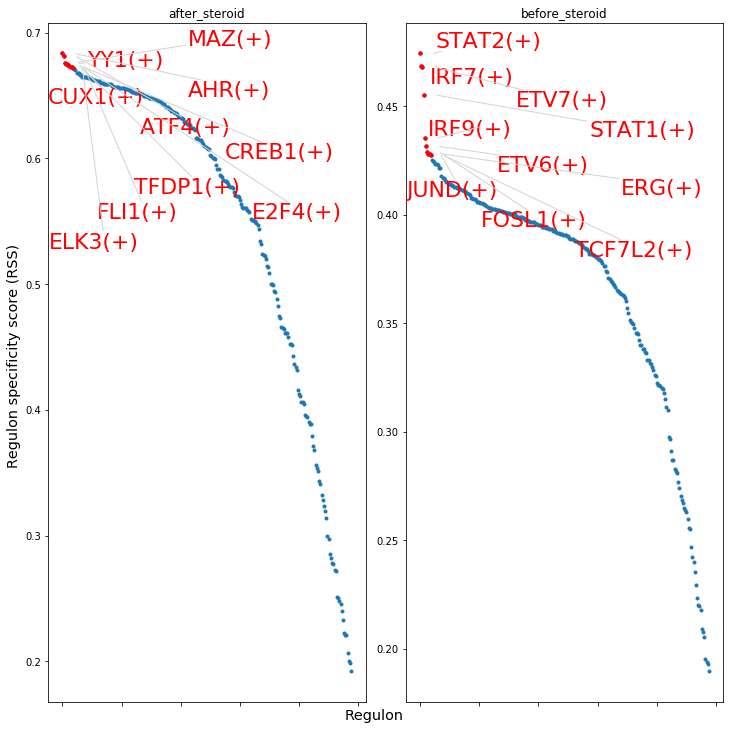

In [36]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
from pyscenic.plotting import plot_rss
# RSS panel plot with all cell types
cats = sorted(list(set(adata.obs['steroid_timeline'])))

fig = plt.figure(figsize=(10, 10))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]

    ax = fig.add_subplot(1,2,num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(22)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })

plt.show()

# heatmap

In [42]:
# Select top 5 regulons per cell type 
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [37]:
# Generate a Z-score for each regulon to enable comparison between regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

/tmp/ipykernel_3392/3030560653.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_3392/3030560653.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_3392/3030560653.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [38]:
# Generate heatmap
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [39]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in adata.obs['steroid_timeline'] ]

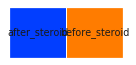

In [40]:
import matplotlib as mpl
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/home/jovyan/my-conda-envs/Py_env2/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 11.551999999999694, '')

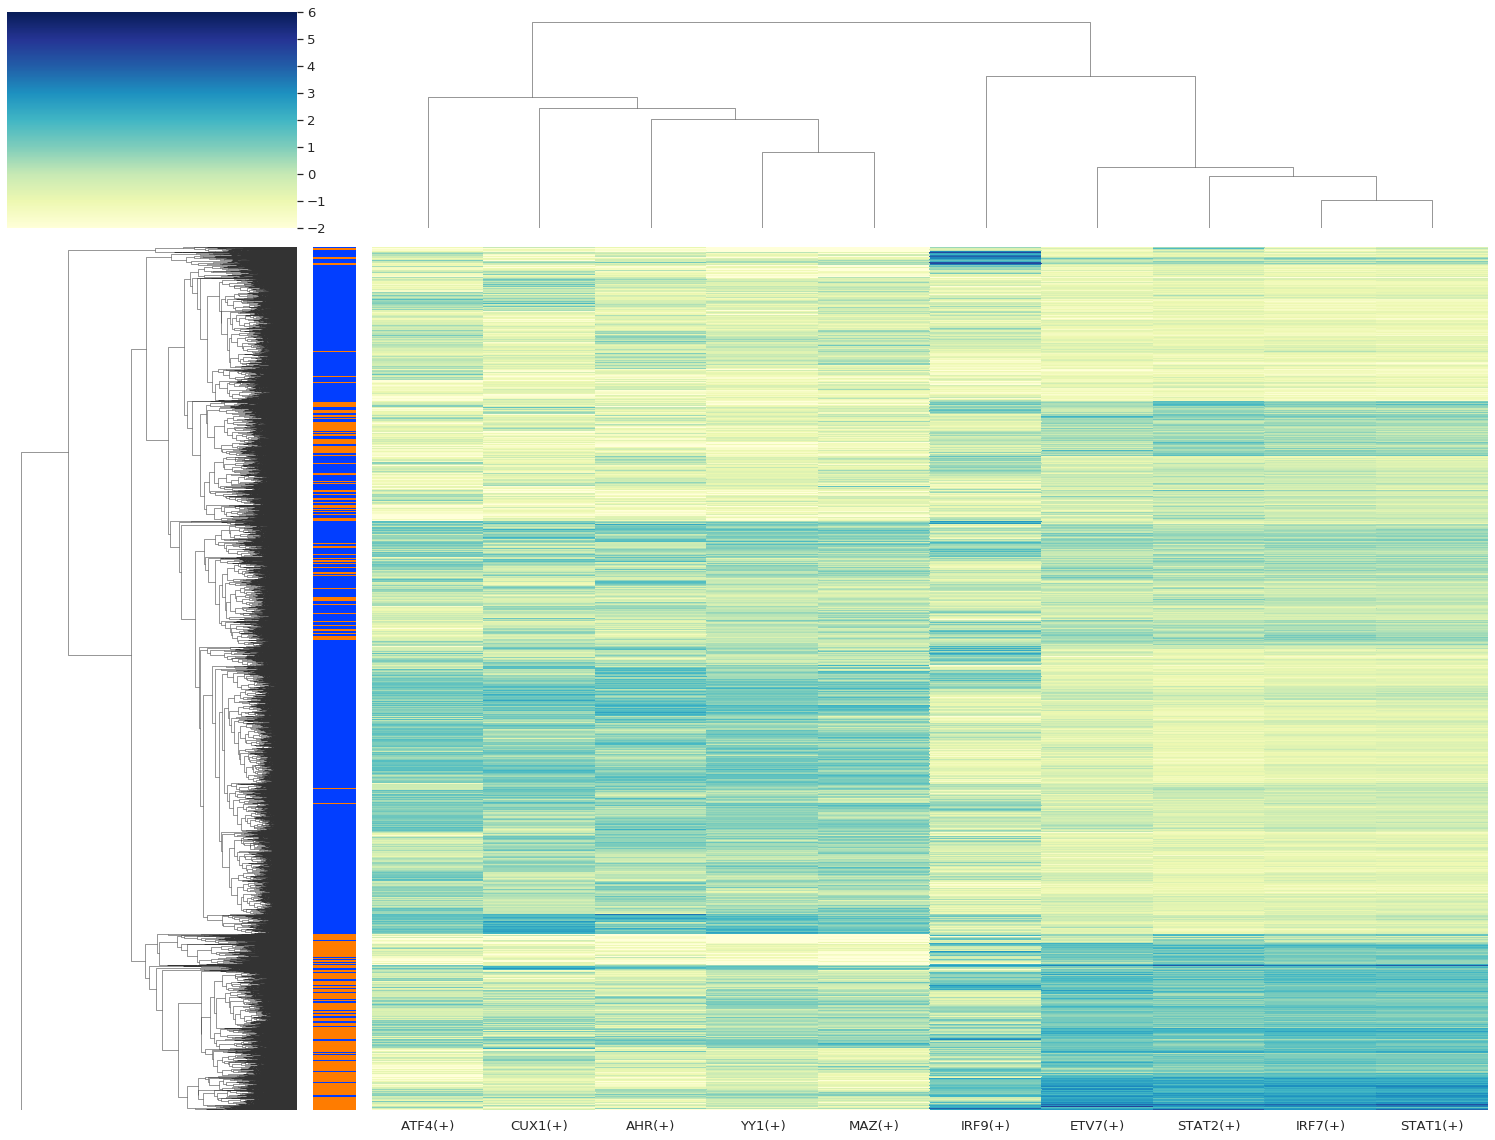

In [43]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,row_cluster=True,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')

# display motif

In [45]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [46]:
#BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
def fetch_logo(regulon, base_url = BASE_URL):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [47]:
import operator as op
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [48]:
from IPython.display import HTML, display
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons.head(10).to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

/tmp/ipykernel_3392/4240729587.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,name,count,logo
0,ADNP(+),5,
1,AHR(+),228,
2,AHRR(+),15,
3,ARID3A(+),8,
4,ARNT(+),87,
5,ARNT2(+),15,
6,ARNTL2(+),53,
7,ATF1(+),105,
8,ATF2(+),23,
9,ATF3(+),244,


# AUC and density

In [50]:
from pyscenic.binarization import binarize
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

Regulon,ADNP(+),AHR(+),AHRR(+),ARID3A(+),ARNT(+),ARNT2(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),...,ZNF543(+),ZNF547(+),ZNF554(+),ZNF585B(+),ZNF597(+),ZNF69(+),ZNF786(+),ZNF853(+),ZNF879(+),ZSCAN10(+)
Cell,,,,,,,,,,,,,,,,,,,,,
UK-CIC10690366+UK-CIC10690558_AACTTTCCAAGTCATC-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
UK-CIC10690366+UK-CIC10690558_TATTACCAGAGTAATC-1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
UK-CIC10690367+UK-CIC10690559_TTGGCAAGTATATGGA-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UK-CIC10690325+UK-CIC10690517_GCGCGATCACCCAGTG-1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UK-CIC10690319+UK-CIC10690511_GCTTGAAAGATCCCAT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


/home/jovyan/my-conda-envs/Py_env2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/my-conda-envs/Py_env2/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/jovyan/my-conda-envs/Py_env2/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/jovyan/my-conda-

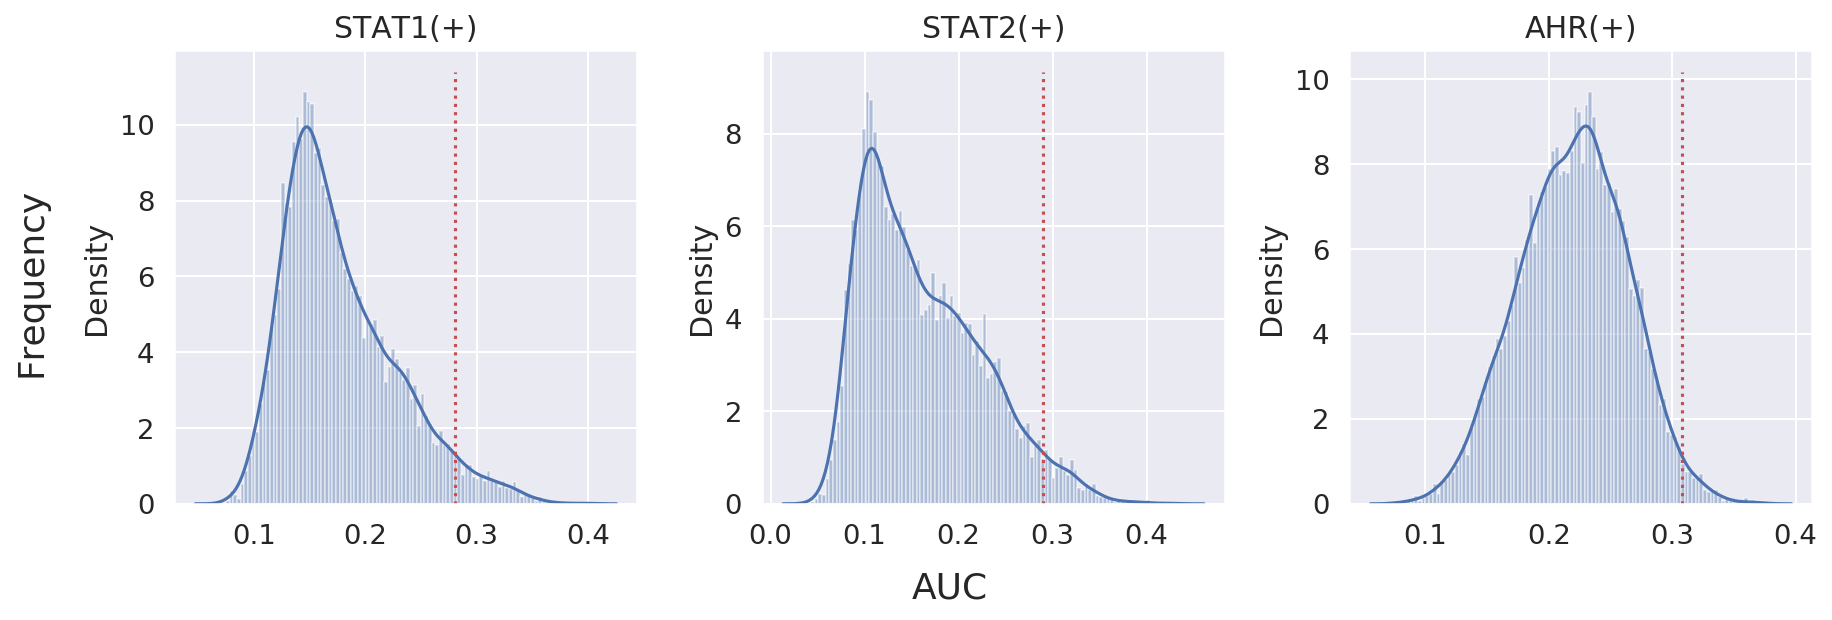

In [51]:
# select regulons:
r = [ 'STAT1(+)', 'STAT2(+)', 'AHR(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('/home/jovyan/scripts/renal_covid_19/steroid_pipeline/regulon_analysis/auc_CD14_wave2_steroid_2021_auc_mtx.png', dpi=600, bbox_inches='tight')